<a href="https://colab.research.google.com/github/sri299792458/stat8105_finetuning_paligemma/blob/main/big_vision/configs/proj/paligemma/finetune_paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune PaliGemma

> *These models and code are not official Google products and were trained and released for research purposes.*


**This notebook shows how to finetune PaliGemma 2 on a vision-language task.**
The training data consists of 90 pairs of images and long captions describing them.
To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 **This setup is illustrative**. In a real usecase, the amount of data, trainable parameters, training steps and hyper-parameters and obtained results could be significantly different.

This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [2]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [3]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "/content/paligemma_assets/paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for PaliGemma 1:
# LLM_VARIANT = "gemma_2b"
# MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
# KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "/content/paligemma_assets/paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

# DATA_DIR="./longcap100"
# if not os.path.exists(DATA_DIR):
#   print("Downloading the dataset...")
#   !gsutil -m -q cp -n -r gs://longcap100/ .
#   print(f"Data path: {DATA_DIR}")

## Notebook

In [4]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.3
JAX platform: gpu
JAX devices:  1


In [5]:
# @title Construct model and load params into RAM.

# Define model
# IMPORTANT: Gemma-2 has a "final_logits_softcap" property, we set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [6]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [7]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [8]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [9]:
# ==============================================================================
# SECTION 1: IMPORTS AND CONSTANTS FOR DATA PREP
# ==============================================================================
import os
import glob
import random
import re
import itertools
from PIL import Image
from tqdm.notebook import tqdm

# Constants for our specific dataset and task
PROMPT_PREFIX = "detect grasp"
ORIGINAL_IMG_WIDTH = 640
ORIGINAL_IMG_HEIGHT = 480
SEQLEN = 64
IMAGE_SIZE = 224

# ==============================================================================
# SECTION 2: DATASET CREATION LOGIC
# ==============================================================================

def create_cornell_dataset(root_path):
    """
    Creates the full list of training examples from the Cornell Grasp dataset
    using the official PaliGemma detection format.
    """
    print(f"Searching for annotation files in: {root_path}")
    annotation_files = glob.glob(os.path.join(root_path, '**', '*cpos.txt'), recursive=True)

    data_examples = []
    skipped_files = 0

    print("Processing annotation files...")
    for txt_file in tqdm(annotation_files, desc="Processing files"):
        image_path = txt_file.replace('cpos.txt', 'r.png')
        if os.path.exists(image_path):
            try:
                with open(txt_file, 'r') as f:
                    lines = f.read().strip().split('\n')

                for i in range(0, len(lines), 4):
                    if i + 3 < len(lines):
                        coords = [lines[i+j].split() for j in range(4)]
                        x_coords = [float(p[0]) for p in coords]
                        y_coords = [float(p[1]) for p in coords]

                        xmin, ymin = min(x_coords), min(y_coords)
                        xmax, ymax = max(x_coords), max(y_coords)

                        loc_ymin = f"<loc{int((ymin / ORIGINAL_IMG_HEIGHT) * 1024)}>"
                        loc_xmin = f"<loc{int((xmin / ORIGINAL_IMG_WIDTH) * 1024)}>"
                        loc_ymax = f"<loc{int((ymax / ORIGINAL_IMG_HEIGHT) * 1024)}>"
                        loc_xmax = f"<loc{int((xmax / ORIGINAL_IMG_WIDTH) * 1024)}>"

                        suffix = f"{loc_ymin}{loc_xmin}{loc_ymax}{loc_xmax} grasp"
                        data_examples.append({'image_path': image_path, 'suffix': suffix})
            except Exception:
                skipped_files += 1
                continue

    if skipped_files > 0:
        print(f"  [!] Total skipped files due to errors: {skipped_files}")

    return data_examples

# ==============================================================================
# SECTION 3: FINAL DATA ITERATOR DEFINITIONS
# ==============================================================================

# 1. Create the full list of examples from our custom dataset
local_dataset_path = '/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle' # Assumes data was copied locally
all_examples = create_cornell_dataset(local_dataset_path)
random.shuffle(all_examples)

# 2. Split into training and validation sets
split_ratio = 0.9
split_idx = int(len(all_examples) * split_ratio)
train_examples = all_examples[:split_idx]
val_examples = all_examples[split_idx:]
print(f"\nDataset created: {len(train_examples)} training examples, {len(val_examples)} validation examples.")

# 3. Define the iterator functions with the required names
def train_data_iterator():
    """Never-ending iterator over our custom training examples."""
    for example in itertools.cycle(train_examples):
        image = Image.open(example["image_path"])
        image = preprocess_image(image)
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(
            prefix=PROMPT_PREFIX, suffix=example["suffix"], seqlen=SEQLEN)
        yield {"image": image, "text": tokens, "mask_ar": mask_ar, "mask_loss": mask_loss}

def validation_data_iterator():
    """Single iterator over validation examples, using tf.data for full compatibility."""

    # A generator function is needed for tf.data.Dataset
    def validation_generator():
        for example in val_examples:
            image = Image.open(example["image_path"])
            image_processed = preprocess_image(image)

            tokens, mask_ar, _, mask_input = preprocess_tokens(
                prefix=PROMPT_PREFIX, seqlen=SEQLEN) # Using your desired SEQLEN

            yield {
                "image": image_processed,
                "text": tokens,
                "mask_ar": mask_ar,
                "mask_input": mask_input
            }

    # Define the exact shape and type of each element the generator yields
    output_signature = {
        "image": tf.TensorSpec(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
        "text": tf.TensorSpec(shape=(SEQLEN,), dtype=tf.int32),
        "mask_ar": tf.TensorSpec(shape=(SEQLEN,), dtype=tf.int32),
        "mask_input": tf.TensorSpec(shape=(SEQLEN,), dtype=tf.int32),
    }

    # Create the tf.data.Dataset from our generator
    val_tf_dataset = tf.data.Dataset.from_generator(
        validation_generator,
        output_signature=output_signature
    )

    # Yield from the dataset's numpy iterator, just like the original notebook
    for example in val_tf_dataset.as_numpy_iterator():
        yield example

Searching for annotation files in: /content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle
Processing annotation files...


Processing files:   0%|          | 0/885 [00:00<?, ?it/s]

  [!] Total skipped files due to errors: 1

Dataset created: 4599 training examples, 511 validation examples.


In [10]:
import base64
import html
import io
import re
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, HTML

# --- Function to decode the model's token output into pixel coordinates ---
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        # Return as [xmin, ymin, xmax, ymax] for PIL's rectangle function
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError):
        return None

# --- Helper function from the original notebook to display images ---
def render_inline(image, resize=(256, 256)):
    """Convert PIL image into inline HTML."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_detection_example(image_array, model_output):
    """
    Renders an image with its predicted bounding box, now with correct coordinate scaling.
    """
    # Convert from [-1, 1] numpy array to a [0, 255] PIL Image
    # The size of this image will be 224x224 pixels.
    image_array = ((image_array + 1) / 2 * 255).astype(np.uint8)
    image = Image.fromarray(image_array)
    draw = ImageDraw.Draw(image)

    # Decode coordinates, which are relative to the ORIGINAL 640x480 size
    bbox_coords_orig = decode_bbox_from_output(model_output)

    if bbox_coords_orig:
        # --- THE FIX IS HERE ---
        # We must rescale the coordinates from the original 640x480 space
        # to the 224x224 space of the image we are drawing on.
        xmin_orig, ymin_orig, xmax_orig, ymax_orig = bbox_coords_orig

        display_width, display_height = image.size # This will be (224, 224)

        xmin_new = int(xmin_orig * (display_width / ORIGINAL_IMG_WIDTH))
        ymin_new = int(ymin_orig * (display_height / ORIGINAL_IMG_HEIGHT))
        xmax_new = int(xmax_orig * (display_width / ORIGINAL_IMG_WIDTH))
        ymax_new = int(ymax_orig * (display_height / ORIGINAL_IMG_HEIGHT))

        rescaled_coords = [xmin_new, ymin_new, xmax_new, ymax_new]

        # Draw the correctly RESCALED bounding box
        draw.rectangle(rescaled_coords, outline='red', width=2)

    # Create the HTML display block
    return (f'<div style="display: inline-flex; flex-direction: column; margin: 10px;">'
            f'<img style="width:256px; height: 256px;" src="{render_inline(image)}" />'
            f'<p style="width: 256px; margin-top: 5px; font-family: monospace; text-align: center;">{html.escape(model_output)}</p>'
            f'</div>')

In [11]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens, normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

Starting training for 574 steps...
step:   1/574 | lr: 0.00052 | loss: 0.9050

--- Running evaluation at step 1 ---



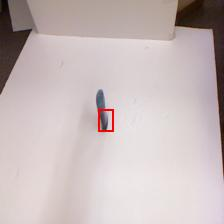
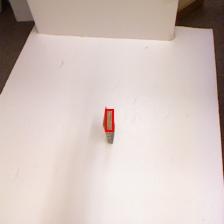
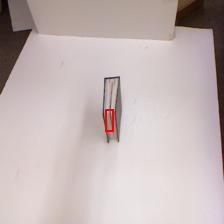
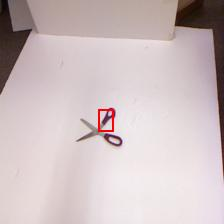

--- Evaluation complete ---

step:   2/574 | lr: 0.00103 | loss: 0.9454
step:   3/574 | lr: 0.00155 | loss: 0.9630
step:   4/574 | lr: 0.00207 | loss: 0.9399
step:   5/574 | lr: 0.00259 | loss: 0.9404
step:   6/574 | lr: 0.00310 | loss: 0.9599
step:   7/574 | lr: 0.00362 | loss: 0.9011
step:   8/574 | lr: 0.00414 | loss: 0.9130
step:   9/574 | lr: 0.00466 | loss: 0.9277
step:  10/574 | lr: 0.00517 | loss: 0.9614
step:  11/574 | lr: 0.00569 | loss: 0.9223
step:  12/574 | lr: 0.00621 | loss: 0.8727
step:  13/574 | lr: 0.00672 | loss: 0.9010
step:  14/574 | lr: 0.00724 | loss: 0.9287
step:  15/574 | lr: 0.00776 | loss: 0.9521
step:  16/574 | lr: 0.00828 | loss: 0.9012
step:  17/574 | lr: 0.00879 | loss: 0.9864
step:  18/574 | lr: 0.00931 | loss: 0.9107
step:  19/574 | lr: 0.00983 | loss: 0.9070
step:  20/574 | lr: 0.01034 | loss: 0.9845

--- Running evaluation at step 20 ---



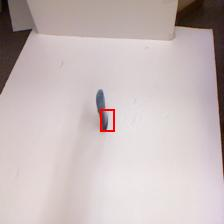
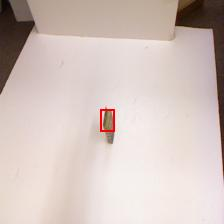
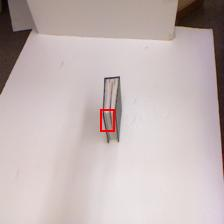
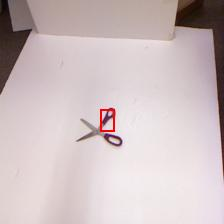

--- Evaluation complete ---

step:  21/574 | lr: 0.01086 | loss: 0.9305
step:  22/574 | lr: 0.01138 | loss: 0.9292
step:  23/574 | lr: 0.01190 | loss: 0.9470
step:  24/574 | lr: 0.01241 | loss: 0.9332
step:  25/574 | lr: 0.01293 | loss: 0.9146
step:  26/574 | lr: 0.01345 | loss: 0.9317
step:  27/574 | lr: 0.01397 | loss: 0.9213
step:  28/574 | lr: 0.01448 | loss: 0.9500
step:  29/574 | lr: 0.01500 | loss: 0.9503
step:  30/574 | lr: 0.01552 | loss: 0.9150
step:  31/574 | lr: 0.01603 | loss: 0.9259
step:  32/574 | lr: 0.01655 | loss: 0.9358
step:  33/574 | lr: 0.01707 | loss: 0.9407
step:  34/574 | lr: 0.01759 | loss: 0.9016
step:  35/574 | lr: 0.01810 | loss: 0.9177
step:  36/574 | lr: 0.01862 | loss: 0.8814
step:  37/574 | lr: 0.01914 | loss: 0.9189
step:  38/574 | lr: 0.01966 | loss: 0.9301
step:  39/574 | lr: 0.02017 | loss: 0.9248
step:  40/574 | lr: 0.02069 | loss: 0.9152

--- Running evaluation at step 40 ---



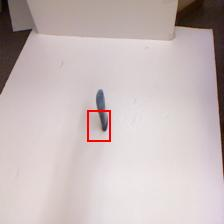
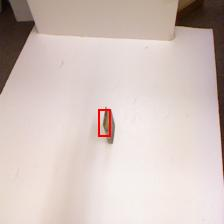
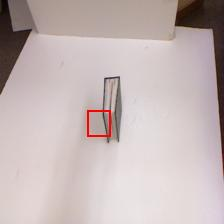
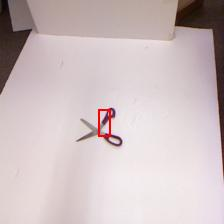

--- Evaluation complete ---

step:  41/574 | lr: 0.02121 | loss: 0.9229
step:  42/574 | lr: 0.02172 | loss: 0.9053
step:  43/574 | lr: 0.02224 | loss: 0.9216
step:  44/574 | lr: 0.02276 | loss: 0.9642
step:  45/574 | lr: 0.02328 | loss: 0.9582
step:  46/574 | lr: 0.02379 | loss: 0.9883
step:  47/574 | lr: 0.02431 | loss: 0.9343
step:  48/574 | lr: 0.02483 | loss: 0.9157
step:  49/574 | lr: 0.02534 | loss: 0.9184
step:  50/574 | lr: 0.02586 | loss: 0.9274
step:  51/574 | lr: 0.02638 | loss: 0.9349
step:  52/574 | lr: 0.02690 | loss: 0.9771
step:  53/574 | lr: 0.02741 | loss: 0.9494
step:  54/574 | lr: 0.02793 | loss: 0.9016
step:  55/574 | lr: 0.02845 | loss: 0.8764
step:  56/574 | lr: 0.02897 | loss: 0.9694
step:  57/574 | lr: 0.02948 | loss: 0.9557
step:  58/574 | lr: 0.03000 | loss: 0.9310
step:  59/574 | lr: 0.03000 | loss: 0.9718
step:  60/574 | lr: 0.03000 | loss: 0.9119

--- Running evaluation at step 60 ---



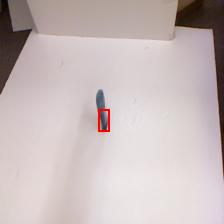
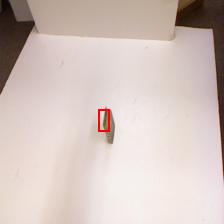
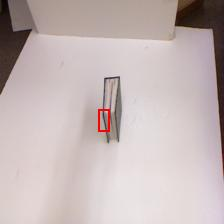
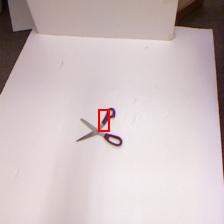

--- Evaluation complete ---

step:  61/574 | lr: 0.03000 | loss: 0.9410
step:  62/574 | lr: 0.03000 | loss: 0.9155
step:  63/574 | lr: 0.02999 | loss: 0.9247
step:  64/574 | lr: 0.02999 | loss: 0.9034
step:  65/574 | lr: 0.02999 | loss: 0.9178
step:  66/574 | lr: 0.02998 | loss: 0.9927
step:  67/574 | lr: 0.02998 | loss: 0.9537
step:  68/574 | lr: 0.02997 | loss: 0.9401
step:  69/574 | lr: 0.02997 | loss: 0.9113
step:  70/574 | lr: 0.02996 | loss: 0.9608
step:  71/574 | lr: 0.02995 | loss: 0.9364
step:  72/574 | lr: 0.02995 | loss: 0.9615
step:  73/574 | lr: 0.02994 | loss: 0.8980
step:  74/574 | lr: 0.02993 | loss: 0.9608
step:  75/574 | lr: 0.02992 | loss: 0.9054
step:  76/574 | lr: 0.02991 | loss: 0.8970
step:  77/574 | lr: 0.02990 | loss: 0.9306
step:  78/574 | lr: 0.02989 | loss: 0.8842
step:  79/574 | lr: 0.02988 | loss: 0.9743
step:  80/574 | lr: 0.02987 | loss: 0.9101

--- Running evaluation at step 80 ---



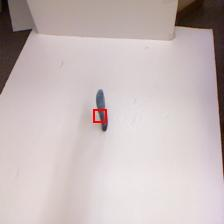
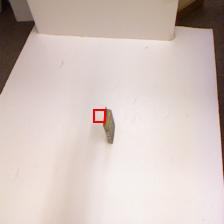
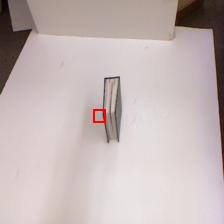
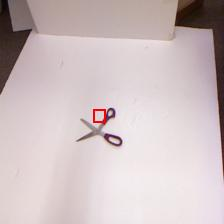

--- Evaluation complete ---

step:  81/574 | lr: 0.02985 | loss: 0.9612
step:  82/574 | lr: 0.02984 | loss: 0.9139
step:  83/574 | lr: 0.02983 | loss: 0.8866
step:  84/574 | lr: 0.02981 | loss: 0.9156
step:  85/574 | lr: 0.02980 | loss: 1.0137
step:  86/574 | lr: 0.02978 | loss: 0.9750
step:  87/574 | lr: 0.02977 | loss: 0.9034
step:  88/574 | lr: 0.02975 | loss: 0.8417
step:  89/574 | lr: 0.02973 | loss: 0.9073
step:  90/574 | lr: 0.02972 | loss: 0.9344
step:  91/574 | lr: 0.02970 | loss: 0.9420
step:  92/574 | lr: 0.02968 | loss: 0.9052
step:  93/574 | lr: 0.02966 | loss: 0.9494
step:  94/574 | lr: 0.02964 | loss: 0.9230
step:  95/574 | lr: 0.02962 | loss: 0.8744
step:  96/574 | lr: 0.02960 | loss: 0.9650
step:  97/574 | lr: 0.02958 | loss: 0.9520
step:  98/574 | lr: 0.02956 | loss: 0.9435
step:  99/574 | lr: 0.02954 | loss: 0.9072
step: 100/574 | lr: 0.02951 | loss: 0.9491

--- Running evaluation at step 100 ---



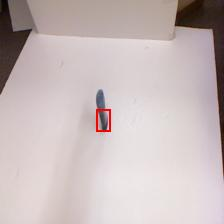
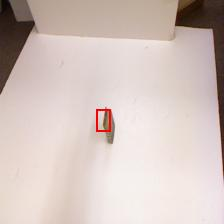
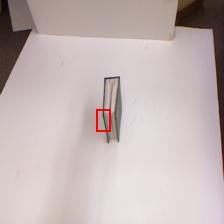
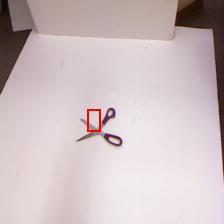

--- Evaluation complete ---

step: 101/574 | lr: 0.02949 | loss: 0.8732
step: 102/574 | lr: 0.02947 | loss: 0.8941
step: 103/574 | lr: 0.02944 | loss: 0.9532
step: 104/574 | lr: 0.02942 | loss: 0.9227
step: 105/574 | lr: 0.02939 | loss: 0.9082
step: 106/574 | lr: 0.02937 | loss: 0.9943
step: 107/574 | lr: 0.02934 | loss: 0.9807
step: 108/574 | lr: 0.02931 | loss: 0.9179
step: 109/574 | lr: 0.02929 | loss: 0.9511
step: 110/574 | lr: 0.02926 | loss: 0.9714
step: 111/574 | lr: 0.02923 | loss: 0.9390
step: 112/574 | lr: 0.02920 | loss: 0.9264
step: 113/574 | lr: 0.02917 | loss: 0.8862
step: 114/574 | lr: 0.02914 | loss: 0.9029
step: 115/574 | lr: 0.02911 | loss: 0.9308
step: 116/574 | lr: 0.02908 | loss: 0.9168
step: 117/574 | lr: 0.02905 | loss: 0.9482
step: 118/574 | lr: 0.02901 | loss: 0.9338
step: 119/574 | lr: 0.02898 | loss: 0.9527
step: 120/574 | lr: 0.02895 | loss: 0.9093

--- Running evaluation at step 120 ---



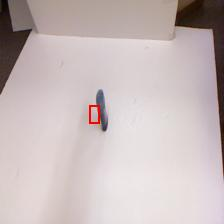
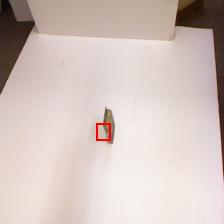
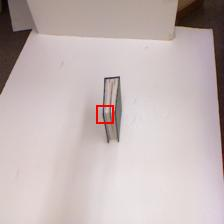
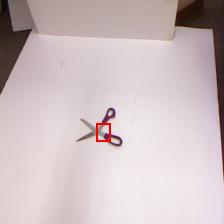

--- Evaluation complete ---

step: 121/574 | lr: 0.02891 | loss: 0.8716
step: 122/574 | lr: 0.02888 | loss: 0.9472
step: 123/574 | lr: 0.02885 | loss: 0.9492
step: 124/574 | lr: 0.02881 | loss: 0.9380
step: 125/574 | lr: 0.02877 | loss: 0.9077
step: 126/574 | lr: 0.02874 | loss: 0.9255
step: 127/574 | lr: 0.02870 | loss: 0.9783
step: 128/574 | lr: 0.02866 | loss: 0.8763
step: 129/574 | lr: 0.02863 | loss: 0.8890
step: 130/574 | lr: 0.02859 | loss: 0.9326
step: 131/574 | lr: 0.02855 | loss: 0.9330
step: 132/574 | lr: 0.02851 | loss: 0.9246
step: 133/574 | lr: 0.02847 | loss: 0.8970
step: 134/574 | lr: 0.02843 | loss: 0.8978
step: 135/574 | lr: 0.02839 | loss: 0.8620
step: 136/574 | lr: 0.02835 | loss: 0.9962
step: 137/574 | lr: 0.02830 | loss: 0.9233
step: 138/574 | lr: 0.02826 | loss: 0.9179
step: 139/574 | lr: 0.02822 | loss: 0.9440
step: 140/574 | lr: 0.02818 | loss: 0.9191

--- Running evaluation at step 140 ---



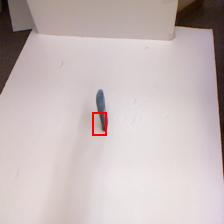
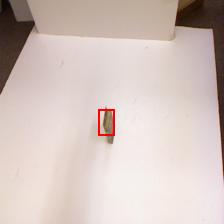
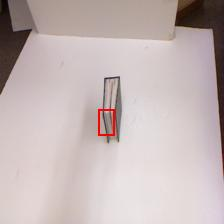
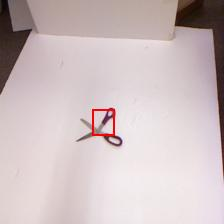

--- Evaluation complete ---

step: 141/574 | lr: 0.02813 | loss: 0.9285
step: 142/574 | lr: 0.02809 | loss: 0.8941
step: 143/574 | lr: 0.02804 | loss: 0.8813
step: 144/574 | lr: 0.02800 | loss: 0.8616
step: 145/574 | lr: 0.02795 | loss: 0.8707
step: 146/574 | lr: 0.02791 | loss: 0.8736
step: 147/574 | lr: 0.02786 | loss: 0.8935
step: 148/574 | lr: 0.02781 | loss: 0.9203
step: 149/574 | lr: 0.02776 | loss: 0.9078
step: 150/574 | lr: 0.02772 | loss: 0.8517
step: 151/574 | lr: 0.02767 | loss: 0.9238
step: 152/574 | lr: 0.02762 | loss: 0.8861
step: 153/574 | lr: 0.02757 | loss: 0.8962
step: 154/574 | lr: 0.02752 | loss: 0.8871
step: 155/574 | lr: 0.02747 | loss: 0.9337
step: 156/574 | lr: 0.02742 | loss: 0.8938
step: 157/574 | lr: 0.02737 | loss: 0.9649
step: 158/574 | lr: 0.02731 | loss: 0.9075
step: 159/574 | lr: 0.02726 | loss: 0.9694
step: 160/574 | lr: 0.02721 | loss: 0.9691

--- Running evaluation at step 160 ---



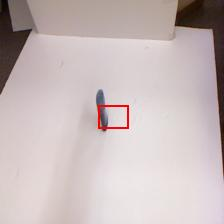
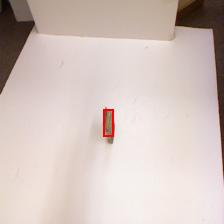
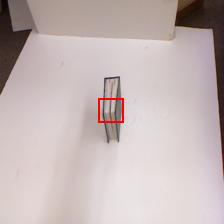
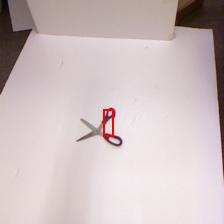

--- Evaluation complete ---

step: 161/574 | lr: 0.02716 | loss: 0.9410
step: 162/574 | lr: 0.02710 | loss: 0.9169
step: 163/574 | lr: 0.02705 | loss: 0.8740
step: 164/574 | lr: 0.02699 | loss: 0.8762
step: 165/574 | lr: 0.02694 | loss: 0.9104
step: 166/574 | lr: 0.02688 | loss: 0.9099
step: 167/574 | lr: 0.02683 | loss: 0.9062
step: 168/574 | lr: 0.02677 | loss: 0.9227
step: 169/574 | lr: 0.02672 | loss: 0.8683
step: 170/574 | lr: 0.02666 | loss: 0.8844
step: 171/574 | lr: 0.02660 | loss: 0.8779
step: 172/574 | lr: 0.02654 | loss: 0.9168
step: 173/574 | lr: 0.02648 | loss: 0.9220
step: 174/574 | lr: 0.02643 | loss: 0.9173
step: 175/574 | lr: 0.02637 | loss: 0.8781
step: 176/574 | lr: 0.02631 | loss: 0.8436
step: 177/574 | lr: 0.02625 | loss: 0.9101
step: 178/574 | lr: 0.02619 | loss: 0.8810
step: 179/574 | lr: 0.02612 | loss: 0.8719
step: 180/574 | lr: 0.02606 | loss: 0.8902

--- Running evaluation at step 180 ---



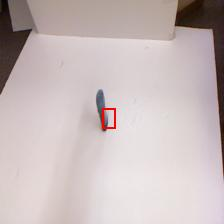
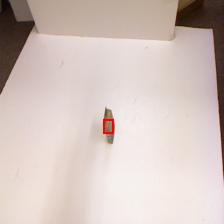
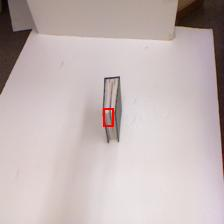
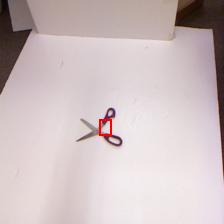

--- Evaluation complete ---

step: 181/574 | lr: 0.02600 | loss: 0.9350
step: 182/574 | lr: 0.02594 | loss: 0.9574
step: 183/574 | lr: 0.02588 | loss: 0.9208
step: 184/574 | lr: 0.02581 | loss: 0.8853
step: 185/574 | lr: 0.02575 | loss: 0.8313
step: 186/574 | lr: 0.02569 | loss: 0.9033
step: 187/574 | lr: 0.02562 | loss: 0.8827
step: 188/574 | lr: 0.02556 | loss: 0.8687
step: 189/574 | lr: 0.02549 | loss: 0.8504
step: 190/574 | lr: 0.02543 | loss: 0.8873
step: 191/574 | lr: 0.02536 | loss: 0.9118
step: 192/574 | lr: 0.02530 | loss: 0.8870
step: 193/574 | lr: 0.02523 | loss: 0.8841
step: 194/574 | lr: 0.02516 | loss: 0.8880
step: 195/574 | lr: 0.02510 | loss: 0.8889
step: 196/574 | lr: 0.02503 | loss: 0.8983
step: 197/574 | lr: 0.02496 | loss: 0.9256
step: 198/574 | lr: 0.02489 | loss: 0.8998
step: 199/574 | lr: 0.02482 | loss: 0.8664
step: 200/574 | lr: 0.02475 | loss: 0.8440

--- Running evaluation at step 200 ---



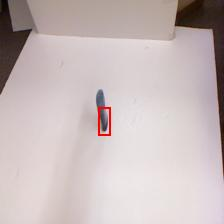
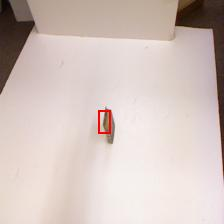
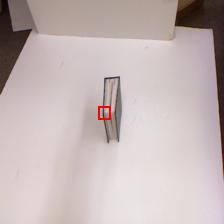
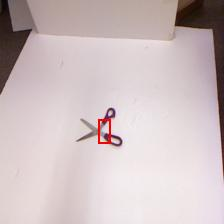

--- Evaluation complete ---

step: 201/574 | lr: 0.02468 | loss: 0.9362
step: 202/574 | lr: 0.02461 | loss: 0.8856
step: 203/574 | lr: 0.02454 | loss: 0.8788
step: 204/574 | lr: 0.02447 | loss: 0.8393
step: 205/574 | lr: 0.02440 | loss: 0.8566
step: 206/574 | lr: 0.02433 | loss: 0.9662
step: 207/574 | lr: 0.02426 | loss: 0.9003
step: 208/574 | lr: 0.02419 | loss: 0.8587
step: 209/574 | lr: 0.02412 | loss: 0.8707
step: 210/574 | lr: 0.02404 | loss: 0.8708
step: 211/574 | lr: 0.02397 | loss: 0.8685
step: 212/574 | lr: 0.02390 | loss: 0.8449
step: 213/574 | lr: 0.02382 | loss: 0.8976
step: 214/574 | lr: 0.02375 | loss: 0.9117
step: 215/574 | lr: 0.02368 | loss: 0.8653
step: 216/574 | lr: 0.02360 | loss: 0.8641
step: 217/574 | lr: 0.02353 | loss: 0.8374
step: 218/574 | lr: 0.02345 | loss: 0.8536
step: 219/574 | lr: 0.02338 | loss: 0.8708
step: 220/574 | lr: 0.02330 | loss: 0.8771

--- Running evaluation at step 220 ---



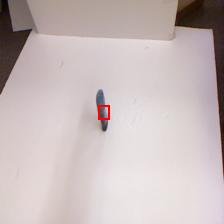
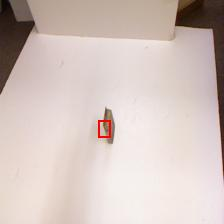
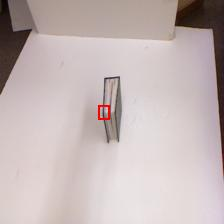
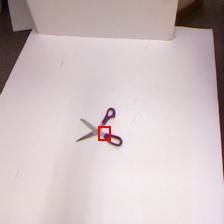

--- Evaluation complete ---

step: 221/574 | lr: 0.02322 | loss: 0.8994
step: 222/574 | lr: 0.02315 | loss: 0.8873
step: 223/574 | lr: 0.02307 | loss: 0.8808
step: 224/574 | lr: 0.02299 | loss: 0.8354
step: 225/574 | lr: 0.02292 | loss: 0.8959
step: 226/574 | lr: 0.02284 | loss: 0.8468
step: 227/574 | lr: 0.02276 | loss: 0.8980
step: 228/574 | lr: 0.02268 | loss: 0.8739
step: 229/574 | lr: 0.02261 | loss: 0.8877
step: 230/574 | lr: 0.02253 | loss: 0.8365
step: 231/574 | lr: 0.02245 | loss: 0.8442
step: 232/574 | lr: 0.02237 | loss: 0.9159
step: 233/574 | lr: 0.02229 | loss: 0.9694
step: 234/574 | lr: 0.02221 | loss: 0.8305
step: 235/574 | lr: 0.02213 | loss: 0.9063
step: 236/574 | lr: 0.02205 | loss: 0.8528
step: 237/574 | lr: 0.02197 | loss: 0.8639
step: 238/574 | lr: 0.02189 | loss: 0.8782
step: 239/574 | lr: 0.02181 | loss: 0.8209
step: 240/574 | lr: 0.02172 | loss: 0.9026

--- Running evaluation at step 240 ---



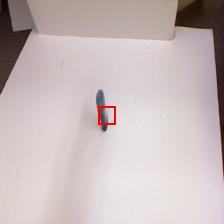
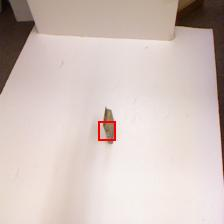
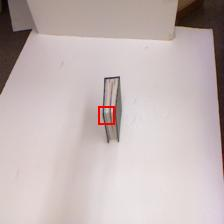
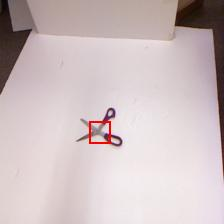

--- Evaluation complete ---

step: 241/574 | lr: 0.02164 | loss: 0.8750
step: 242/574 | lr: 0.02156 | loss: 0.9082
step: 243/574 | lr: 0.02148 | loss: 0.8520
step: 244/574 | lr: 0.02140 | loss: 0.8734
step: 245/574 | lr: 0.02131 | loss: 0.8750
step: 246/574 | lr: 0.02123 | loss: 0.8956
step: 247/574 | lr: 0.02115 | loss: 0.8366
step: 248/574 | lr: 0.02106 | loss: 0.8664
step: 249/574 | lr: 0.02098 | loss: 0.9040
step: 250/574 | lr: 0.02090 | loss: 0.9049
step: 251/574 | lr: 0.02081 | loss: 0.8659
step: 252/574 | lr: 0.02073 | loss: 0.8327
step: 253/574 | lr: 0.02065 | loss: 0.9105
step: 254/574 | lr: 0.02056 | loss: 0.9168
step: 255/574 | lr: 0.02048 | loss: 0.8667
step: 256/574 | lr: 0.02039 | loss: 0.8641
step: 257/574 | lr: 0.02031 | loss: 0.8849
step: 258/574 | lr: 0.02022 | loss: 0.8474
step: 259/574 | lr: 0.02014 | loss: 0.8484
step: 260/574 | lr: 0.02005 | loss: 0.9338

--- Running evaluation at step 260 ---



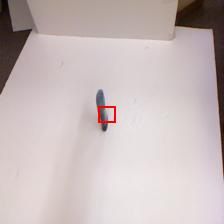
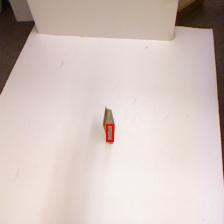
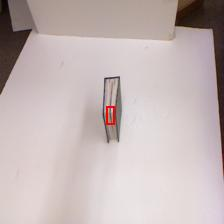
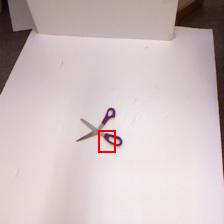

--- Evaluation complete ---

step: 261/574 | lr: 0.01996 | loss: 0.8601
step: 262/574 | lr: 0.01988 | loss: 0.8841
step: 263/574 | lr: 0.01979 | loss: 0.9025
step: 264/574 | lr: 0.01970 | loss: 0.8653
step: 265/574 | lr: 0.01962 | loss: 0.8199
step: 266/574 | lr: 0.01953 | loss: 0.8265
step: 267/574 | lr: 0.01944 | loss: 0.9049
step: 268/574 | lr: 0.01936 | loss: 0.8617
step: 269/574 | lr: 0.01927 | loss: 0.9096
step: 270/574 | lr: 0.01918 | loss: 0.8196
step: 271/574 | lr: 0.01909 | loss: 0.7911
step: 272/574 | lr: 0.01901 | loss: 0.8178
step: 273/574 | lr: 0.01892 | loss: 0.8502
step: 274/574 | lr: 0.01883 | loss: 0.7953
step: 275/574 | lr: 0.01874 | loss: 0.8883
step: 276/574 | lr: 0.01865 | loss: 0.9084
step: 277/574 | lr: 0.01857 | loss: 0.8796
step: 278/574 | lr: 0.01848 | loss: 0.8070
step: 279/574 | lr: 0.01839 | loss: 0.8254
step: 280/574 | lr: 0.01830 | loss: 0.8645

--- Running evaluation at step 280 ---



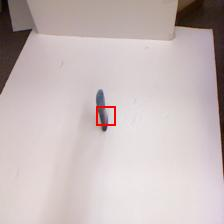
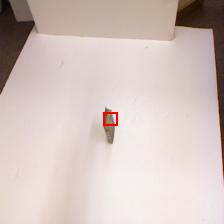
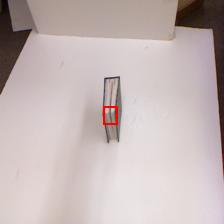
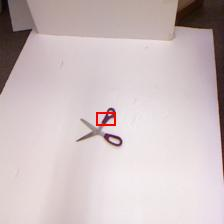

--- Evaluation complete ---

step: 281/574 | lr: 0.01821 | loss: 0.8771
step: 282/574 | lr: 0.01812 | loss: 0.8715
step: 283/574 | lr: 0.01803 | loss: 0.8552
step: 284/574 | lr: 0.01794 | loss: 0.8285
step: 285/574 | lr: 0.01785 | loss: 0.9185
step: 286/574 | lr: 0.01776 | loss: 0.8470
step: 287/574 | lr: 0.01767 | loss: 0.8230
step: 288/574 | lr: 0.01758 | loss: 0.9025
step: 289/574 | lr: 0.01749 | loss: 0.8642
step: 290/574 | lr: 0.01741 | loss: 0.8648
step: 291/574 | lr: 0.01732 | loss: 0.8726
step: 292/574 | lr: 0.01722 | loss: 0.8250
step: 293/574 | lr: 0.01713 | loss: 0.8813
step: 294/574 | lr: 0.01704 | loss: 0.8807
step: 295/574 | lr: 0.01695 | loss: 0.8531
step: 296/574 | lr: 0.01686 | loss: 0.8480
step: 297/574 | lr: 0.01677 | loss: 0.8700
step: 298/574 | lr: 0.01668 | loss: 0.8117
step: 299/574 | lr: 0.01659 | loss: 0.8728
step: 300/574 | lr: 0.01650 | loss: 0.8563

--- Running evaluation at step 300 ---



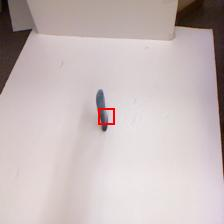
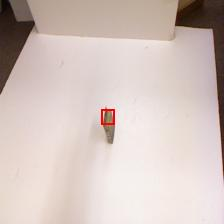
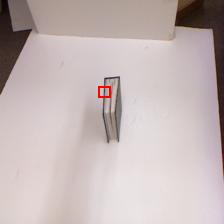
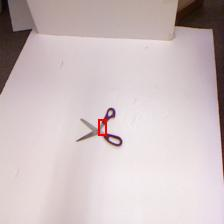

--- Evaluation complete ---

step: 301/574 | lr: 0.01641 | loss: 0.8620
step: 302/574 | lr: 0.01632 | loss: 0.8642
step: 303/574 | lr: 0.01623 | loss: 0.8656
step: 304/574 | lr: 0.01614 | loss: 0.8228
step: 305/574 | lr: 0.01605 | loss: 0.8913
step: 306/574 | lr: 0.01596 | loss: 0.8670
step: 307/574 | lr: 0.01587 | loss: 0.8550
step: 308/574 | lr: 0.01577 | loss: 0.7776
step: 309/574 | lr: 0.01568 | loss: 0.8005
step: 310/574 | lr: 0.01559 | loss: 0.8356
step: 311/574 | lr: 0.01550 | loss: 0.8065
step: 312/574 | lr: 0.01541 | loss: 0.8373
step: 313/574 | lr: 0.01532 | loss: 0.8948
step: 314/574 | lr: 0.01523 | loss: 0.8265
step: 315/574 | lr: 0.01514 | loss: 0.8076
step: 316/574 | lr: 0.01505 | loss: 0.8711
step: 317/574 | lr: 0.01495 | loss: 0.8684
step: 318/574 | lr: 0.01486 | loss: 0.8777
step: 319/574 | lr: 0.01477 | loss: 0.9015
step: 320/574 | lr: 0.01468 | loss: 0.8334

--- Running evaluation at step 320 ---



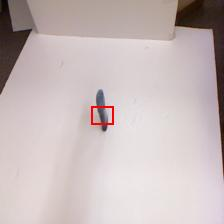
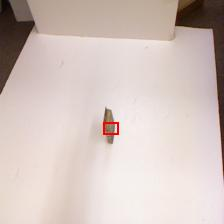
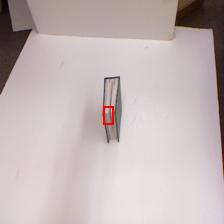
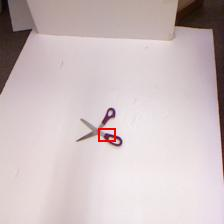

--- Evaluation complete ---

step: 321/574 | lr: 0.01459 | loss: 0.8177
step: 322/574 | lr: 0.01450 | loss: 0.8496
step: 323/574 | lr: 0.01441 | loss: 0.8875
step: 324/574 | lr: 0.01432 | loss: 0.8628
step: 325/574 | lr: 0.01423 | loss: 0.7957
step: 326/574 | lr: 0.01413 | loss: 0.8544
step: 327/574 | lr: 0.01404 | loss: 0.8635
step: 328/574 | lr: 0.01395 | loss: 0.8135
step: 329/574 | lr: 0.01386 | loss: 0.8072
step: 330/574 | lr: 0.01377 | loss: 0.9105
step: 331/574 | lr: 0.01368 | loss: 0.8585
step: 332/574 | lr: 0.01359 | loss: 0.8373
step: 333/574 | lr: 0.01350 | loss: 0.8406
step: 334/574 | lr: 0.01341 | loss: 0.8383
step: 335/574 | lr: 0.01332 | loss: 0.8198
step: 336/574 | lr: 0.01323 | loss: 0.8340
step: 337/574 | lr: 0.01314 | loss: 0.9210
step: 338/574 | lr: 0.01305 | loss: 0.8349
step: 339/574 | lr: 0.01296 | loss: 0.8805
step: 340/574 | lr: 0.01287 | loss: 0.8626

--- Running evaluation at step 340 ---



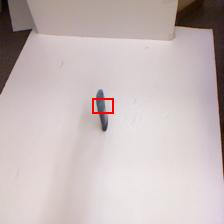
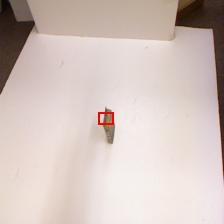
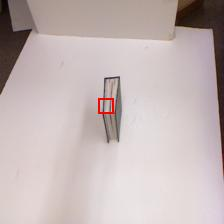
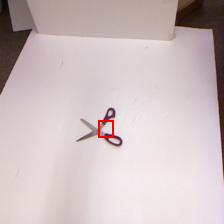

--- Evaluation complete ---

step: 341/574 | lr: 0.01278 | loss: 0.8344
step: 342/574 | lr: 0.01268 | loss: 0.8113
step: 343/574 | lr: 0.01259 | loss: 0.8401
step: 344/574 | lr: 0.01251 | loss: 0.8345
step: 345/574 | lr: 0.01242 | loss: 0.8635
step: 346/574 | lr: 0.01233 | loss: 0.8628
step: 347/574 | lr: 0.01224 | loss: 0.8182
step: 348/574 | lr: 0.01215 | loss: 0.8711
step: 349/574 | lr: 0.01206 | loss: 0.8413
step: 350/574 | lr: 0.01197 | loss: 0.8930
step: 351/574 | lr: 0.01188 | loss: 0.8749
step: 352/574 | lr: 0.01179 | loss: 0.8580
step: 353/574 | lr: 0.01170 | loss: 0.8685
step: 354/574 | lr: 0.01161 | loss: 0.8320
step: 355/574 | lr: 0.01152 | loss: 0.8421
step: 356/574 | lr: 0.01143 | loss: 0.8356
step: 357/574 | lr: 0.01135 | loss: 0.8328
step: 358/574 | lr: 0.01126 | loss: 0.8573
step: 359/574 | lr: 0.01117 | loss: 0.8533
step: 360/574 | lr: 0.01108 | loss: 0.8040

--- Running evaluation at step 360 ---



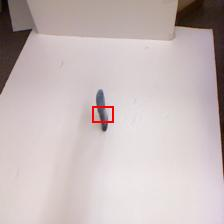
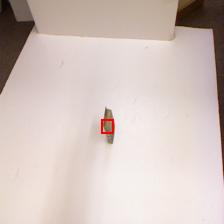
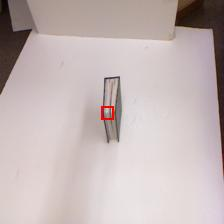
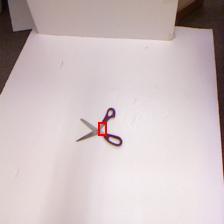

--- Evaluation complete ---

step: 361/574 | lr: 0.01099 | loss: 0.7840
step: 362/574 | lr: 0.01091 | loss: 0.8252
step: 363/574 | lr: 0.01082 | loss: 0.8969
step: 364/574 | lr: 0.01073 | loss: 0.8735
step: 365/574 | lr: 0.01064 | loss: 0.8297
step: 366/574 | lr: 0.01056 | loss: 0.8252
step: 367/574 | lr: 0.01047 | loss: 0.8683
step: 368/574 | lr: 0.01038 | loss: 0.8626
step: 369/574 | lr: 0.01030 | loss: 0.8125
step: 370/574 | lr: 0.01021 | loss: 0.8184
step: 371/574 | lr: 0.01012 | loss: 0.8552
step: 372/574 | lr: 0.01004 | loss: 0.8226
step: 373/574 | lr: 0.00995 | loss: 0.8492
step: 374/574 | lr: 0.00986 | loss: 0.7996
step: 375/574 | lr: 0.00978 | loss: 0.8154
step: 376/574 | lr: 0.00969 | loss: 0.8018
step: 377/574 | lr: 0.00961 | loss: 0.7903
step: 378/574 | lr: 0.00952 | loss: 0.7701
step: 379/574 | lr: 0.00944 | loss: 0.8165
step: 380/574 | lr: 0.00935 | loss: 0.8067

--- Running evaluation at step 380 ---



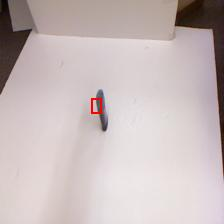
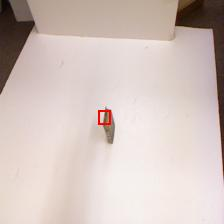
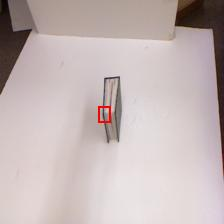
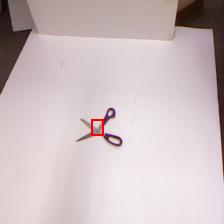

--- Evaluation complete ---

step: 381/574 | lr: 0.00927 | loss: 0.8704
step: 382/574 | lr: 0.00919 | loss: 0.8540
step: 383/574 | lr: 0.00910 | loss: 0.8225
step: 384/574 | lr: 0.00902 | loss: 0.8291
step: 385/574 | lr: 0.00894 | loss: 0.7696
step: 386/574 | lr: 0.00885 | loss: 0.8192
step: 387/574 | lr: 0.00877 | loss: 0.8383
step: 388/574 | lr: 0.00869 | loss: 0.8116
step: 389/574 | lr: 0.00860 | loss: 0.8653
step: 390/574 | lr: 0.00852 | loss: 0.8145
step: 391/574 | lr: 0.00844 | loss: 0.8499
step: 392/574 | lr: 0.00836 | loss: 0.8060
step: 393/574 | lr: 0.00828 | loss: 0.8165
step: 394/574 | lr: 0.00819 | loss: 0.8166
step: 395/574 | lr: 0.00811 | loss: 0.8255
step: 396/574 | lr: 0.00803 | loss: 0.8517
step: 397/574 | lr: 0.00795 | loss: 0.8528
step: 398/574 | lr: 0.00787 | loss: 0.7880
step: 399/574 | lr: 0.00779 | loss: 0.7914
step: 400/574 | lr: 0.00771 | loss: 0.8491

--- Running evaluation at step 400 ---



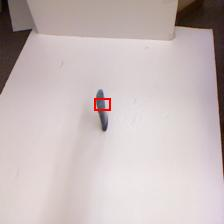
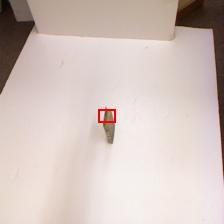
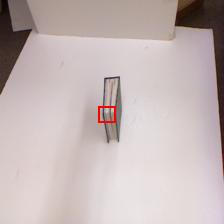
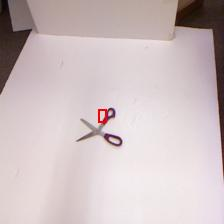

--- Evaluation complete ---

step: 401/574 | lr: 0.00763 | loss: 0.8676
step: 402/574 | lr: 0.00755 | loss: 0.8355
step: 403/574 | lr: 0.00747 | loss: 0.8164
step: 404/574 | lr: 0.00739 | loss: 0.8758
step: 405/574 | lr: 0.00732 | loss: 0.8539
step: 406/574 | lr: 0.00724 | loss: 0.7989
step: 407/574 | lr: 0.00716 | loss: 0.7750
step: 408/574 | lr: 0.00708 | loss: 0.8810
step: 409/574 | lr: 0.00701 | loss: 0.8265
step: 410/574 | lr: 0.00693 | loss: 0.7591
step: 411/574 | lr: 0.00685 | loss: 0.7920
step: 412/574 | lr: 0.00678 | loss: 0.7824
step: 413/574 | lr: 0.00670 | loss: 0.8499
step: 414/574 | lr: 0.00662 | loss: 0.8106
step: 415/574 | lr: 0.00655 | loss: 0.8095
step: 416/574 | lr: 0.00647 | loss: 0.8849
step: 417/574 | lr: 0.00640 | loss: 0.7572
step: 418/574 | lr: 0.00632 | loss: 0.8647
step: 419/574 | lr: 0.00625 | loss: 0.7766
step: 420/574 | lr: 0.00618 | loss: 0.8074

--- Running evaluation at step 420 ---



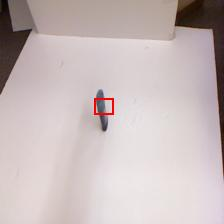
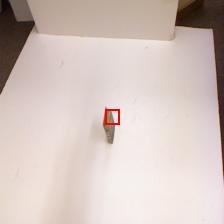
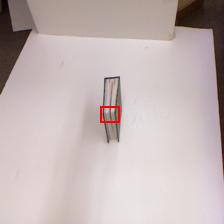
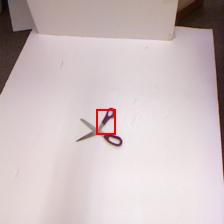

--- Evaluation complete ---

step: 421/574 | lr: 0.00610 | loss: 0.7849
step: 422/574 | lr: 0.00603 | loss: 0.8071
step: 423/574 | lr: 0.00596 | loss: 0.8497
step: 424/574 | lr: 0.00588 | loss: 0.8227
step: 425/574 | lr: 0.00581 | loss: 0.8404
step: 426/574 | lr: 0.00574 | loss: 0.8076
step: 427/574 | lr: 0.00567 | loss: 0.8179
step: 428/574 | lr: 0.00560 | loss: 0.8382
step: 429/574 | lr: 0.00553 | loss: 0.7873
step: 430/574 | lr: 0.00546 | loss: 0.8181
step: 431/574 | lr: 0.00539 | loss: 0.7742
step: 432/574 | lr: 0.00532 | loss: 0.8248
step: 433/574 | lr: 0.00525 | loss: 0.8373
step: 434/574 | lr: 0.00518 | loss: 0.8014
step: 435/574 | lr: 0.00511 | loss: 0.8226
step: 436/574 | lr: 0.00504 | loss: 0.8370
step: 437/574 | lr: 0.00497 | loss: 0.7899
step: 438/574 | lr: 0.00490 | loss: 0.8006
step: 439/574 | lr: 0.00484 | loss: 0.8920
step: 440/574 | lr: 0.00477 | loss: 0.7742

--- Running evaluation at step 440 ---



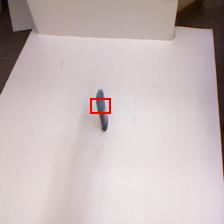
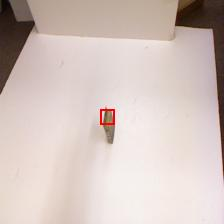
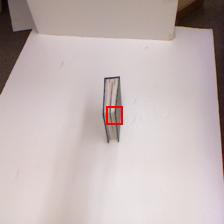
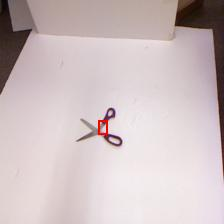

--- Evaluation complete ---

step: 441/574 | lr: 0.00470 | loss: 0.8308
step: 442/574 | lr: 0.00464 | loss: 0.8483
step: 443/574 | lr: 0.00457 | loss: 0.8223
step: 444/574 | lr: 0.00451 | loss: 0.7733
step: 445/574 | lr: 0.00444 | loss: 0.8201
step: 446/574 | lr: 0.00438 | loss: 0.7839
step: 447/574 | lr: 0.00431 | loss: 0.7743
step: 448/574 | lr: 0.00425 | loss: 0.7917
step: 449/574 | lr: 0.00419 | loss: 0.8711
step: 450/574 | lr: 0.00412 | loss: 0.7839
step: 451/574 | lr: 0.00406 | loss: 0.7813
step: 452/574 | lr: 0.00400 | loss: 0.8206
step: 453/574 | lr: 0.00394 | loss: 0.8245
step: 454/574 | lr: 0.00388 | loss: 0.7688
step: 455/574 | lr: 0.00381 | loss: 0.8665
step: 456/574 | lr: 0.00375 | loss: 0.7963
step: 457/574 | lr: 0.00369 | loss: 0.8872
step: 458/574 | lr: 0.00363 | loss: 0.8449
step: 459/574 | lr: 0.00357 | loss: 0.8198
step: 460/574 | lr: 0.00352 | loss: 0.8296

--- Running evaluation at step 460 ---



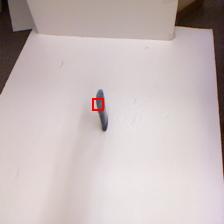
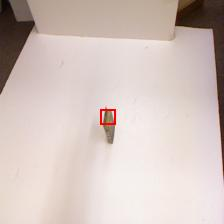
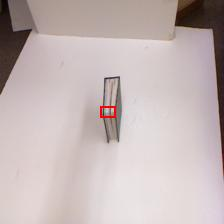
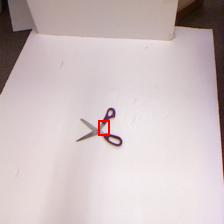

--- Evaluation complete ---

step: 461/574 | lr: 0.00346 | loss: 0.8186
step: 462/574 | lr: 0.00340 | loss: 0.7816
step: 463/574 | lr: 0.00334 | loss: 0.8398
step: 464/574 | lr: 0.00328 | loss: 0.8101
step: 465/574 | lr: 0.00323 | loss: 0.8171
step: 466/574 | lr: 0.00317 | loss: 0.7772
step: 467/574 | lr: 0.00312 | loss: 0.8423
step: 468/574 | lr: 0.00306 | loss: 0.7798
step: 469/574 | lr: 0.00301 | loss: 0.7824
step: 470/574 | lr: 0.00295 | loss: 0.7536
step: 471/574 | lr: 0.00290 | loss: 0.8006
step: 472/574 | lr: 0.00284 | loss: 0.8293
step: 473/574 | lr: 0.00279 | loss: 0.8275
step: 474/574 | lr: 0.00274 | loss: 0.7778
step: 475/574 | lr: 0.00269 | loss: 0.8047
step: 476/574 | lr: 0.00263 | loss: 0.8334
step: 477/574 | lr: 0.00258 | loss: 0.7931
step: 478/574 | lr: 0.00253 | loss: 0.8271
step: 479/574 | lr: 0.00248 | loss: 0.8002
step: 480/574 | lr: 0.00243 | loss: 0.8227

--- Running evaluation at step 480 ---



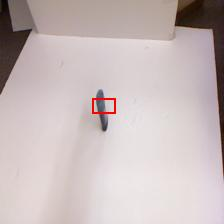
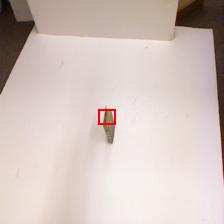
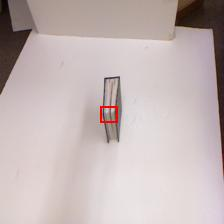
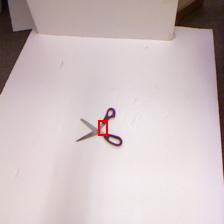

--- Evaluation complete ---

step: 481/574 | lr: 0.00238 | loss: 0.8270
step: 482/574 | lr: 0.00233 | loss: 0.7901
step: 483/574 | lr: 0.00228 | loss: 0.8151
step: 484/574 | lr: 0.00224 | loss: 0.7902
step: 485/574 | lr: 0.00219 | loss: 0.8153
step: 486/574 | lr: 0.00214 | loss: 0.7641
step: 487/574 | lr: 0.00209 | loss: 0.7913
step: 488/574 | lr: 0.00205 | loss: 0.8465
step: 489/574 | lr: 0.00200 | loss: 0.8300
step: 490/574 | lr: 0.00196 | loss: 0.8241
step: 491/574 | lr: 0.00191 | loss: 0.8138
step: 492/574 | lr: 0.00187 | loss: 0.8412
step: 493/574 | lr: 0.00182 | loss: 0.8373
step: 494/574 | lr: 0.00178 | loss: 0.7741
step: 495/574 | lr: 0.00174 | loss: 0.7781
step: 496/574 | lr: 0.00170 | loss: 0.8142
step: 497/574 | lr: 0.00165 | loss: 0.7929
step: 498/574 | lr: 0.00161 | loss: 0.8296
step: 499/574 | lr: 0.00157 | loss: 0.8062
step: 500/574 | lr: 0.00153 | loss: 0.8443

--- Running evaluation at step 500 ---



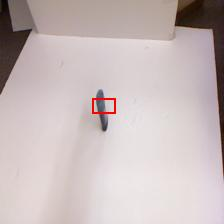
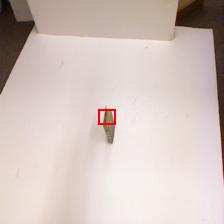
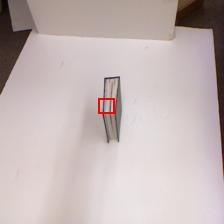
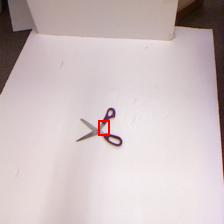

--- Evaluation complete ---

step: 501/574 | lr: 0.00149 | loss: 0.7849
step: 502/574 | lr: 0.00145 | loss: 0.7916
step: 503/574 | lr: 0.00141 | loss: 0.8046
step: 504/574 | lr: 0.00137 | loss: 0.7627
step: 505/574 | lr: 0.00134 | loss: 0.8151
step: 506/574 | lr: 0.00130 | loss: 0.8202
step: 507/574 | lr: 0.00126 | loss: 0.8122
step: 508/574 | lr: 0.00123 | loss: 0.7857
step: 509/574 | lr: 0.00119 | loss: 0.7901
step: 510/574 | lr: 0.00115 | loss: 0.8077
step: 511/574 | lr: 0.00112 | loss: 0.7817
step: 512/574 | lr: 0.00109 | loss: 0.8323
step: 513/574 | lr: 0.00105 | loss: 0.8524
step: 514/574 | lr: 0.00102 | loss: 0.7588
step: 515/574 | lr: 0.00099 | loss: 0.7709
step: 516/574 | lr: 0.00095 | loss: 0.7553
step: 517/574 | lr: 0.00092 | loss: 0.8200
step: 518/574 | lr: 0.00089 | loss: 0.8079
step: 519/574 | lr: 0.00086 | loss: 0.7482
step: 520/574 | lr: 0.00083 | loss: 0.7880

--- Running evaluation at step 520 ---



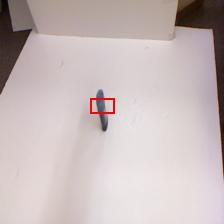
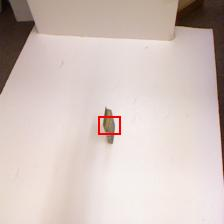
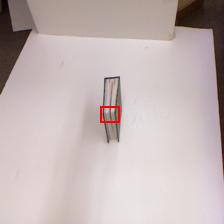
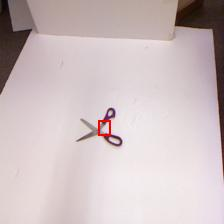

--- Evaluation complete ---

step: 521/574 | lr: 0.00080 | loss: 0.8040
step: 522/574 | lr: 0.00077 | loss: 0.8338
step: 523/574 | lr: 0.00074 | loss: 0.8117
step: 524/574 | lr: 0.00071 | loss: 0.8094
step: 525/574 | lr: 0.00069 | loss: 0.7659
step: 526/574 | lr: 0.00066 | loss: 0.7621
step: 527/574 | lr: 0.00063 | loss: 0.7790
step: 528/574 | lr: 0.00061 | loss: 0.7815
step: 529/574 | lr: 0.00058 | loss: 0.7751
step: 530/574 | lr: 0.00056 | loss: 0.8014
step: 531/574 | lr: 0.00053 | loss: 0.7472
step: 532/574 | lr: 0.00051 | loss: 0.7825
step: 533/574 | lr: 0.00049 | loss: 0.7757
step: 534/574 | lr: 0.00046 | loss: 0.8100
step: 535/574 | lr: 0.00044 | loss: 0.7825
step: 536/574 | lr: 0.00042 | loss: 0.8354
step: 537/574 | lr: 0.00040 | loss: 0.8019
step: 538/574 | lr: 0.00038 | loss: 0.8163
step: 539/574 | lr: 0.00036 | loss: 0.8185
step: 540/574 | lr: 0.00034 | loss: 0.7805

--- Running evaluation at step 540 ---



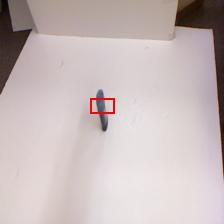
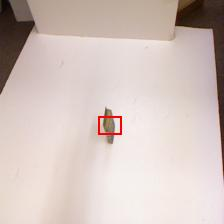
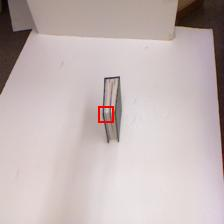
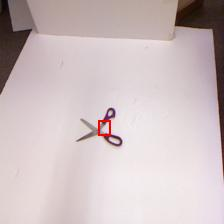

--- Evaluation complete ---

step: 541/574 | lr: 0.00032 | loss: 0.7995
step: 542/574 | lr: 0.00030 | loss: 0.7838
step: 543/574 | lr: 0.00028 | loss: 0.7966
step: 544/574 | lr: 0.00027 | loss: 0.7669
step: 545/574 | lr: 0.00025 | loss: 0.7640
step: 546/574 | lr: 0.00023 | loss: 0.7797
step: 547/574 | lr: 0.00022 | loss: 0.8011
step: 548/574 | lr: 0.00020 | loss: 0.7498
step: 549/574 | lr: 0.00019 | loss: 0.8578
step: 550/574 | lr: 0.00017 | loss: 0.8270
step: 551/574 | lr: 0.00016 | loss: 0.8234
step: 552/574 | lr: 0.00015 | loss: 0.7976
step: 553/574 | lr: 0.00013 | loss: 0.8168
step: 554/574 | lr: 0.00012 | loss: 0.7705
step: 555/574 | lr: 0.00011 | loss: 0.7908
step: 556/574 | lr: 0.00010 | loss: 0.7907
step: 557/574 | lr: 0.00009 | loss: 0.8051
step: 558/574 | lr: 0.00008 | loss: 0.8031
step: 559/574 | lr: 0.00007 | loss: 0.7689
step: 560/574 | lr: 0.00006 | loss: 0.7909

--- Running evaluation at step 560 ---



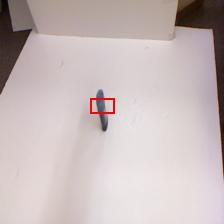
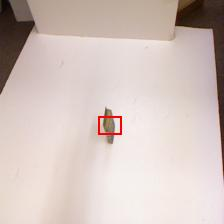
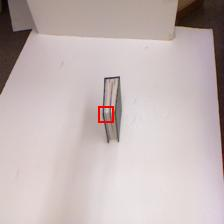
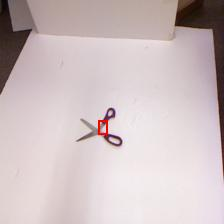

--- Evaluation complete ---

step: 561/574 | lr: 0.00005 | loss: 0.7747
step: 562/574 | lr: 0.00005 | loss: 0.7819
step: 563/574 | lr: 0.00004 | loss: 0.7622
step: 564/574 | lr: 0.00003 | loss: 0.7952
step: 565/574 | lr: 0.00003 | loss: 0.7942
step: 566/574 | lr: 0.00002 | loss: 0.7699
step: 567/574 | lr: 0.00002 | loss: 0.7986
step: 568/574 | lr: 0.00001 | loss: 0.8622
step: 569/574 | lr: 0.00001 | loss: 0.7639
step: 570/574 | lr: 0.00001 | loss: 0.7211
step: 571/574 | lr: 0.00000 | loss: 0.7753
step: 572/574 | lr: 0.00000 | loss: 0.8451
step: 573/574 | lr: 0.00000 | loss: 0.7899
step: 574/574 | lr: 0.00000 | loss: 0.8470

Training finished in 5765.28 seconds.


In [45]:
# ==============================================================================
# FINAL CORRECTED TRAINING LOOP
# ==============================================================================

# --- 1. Define Training Parameters ---
BATCH_SIZE = 8
TRAIN_EXAMPLES = 4599 # Using the full training set for one epoch
LEARNING_RATE = 0.03
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 5

# --- 2. Create Learning Rate Schedule and Training Iterator ---
train_data_it = train_data_iterator()
sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

# --- 3. Run the Training and Evaluation Loop ---
print(f"Starting training for {TRAIN_STEPS} steps...")
start_time = time.time()
for step in range(1, TRAIN_STEPS + 1):
    # --- Training Step ---
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

    # ==========================================================================
    # THE FIX IS HERE: Replaced jax.tree.map with a more explicit batching method.
    # This manually stacks the values for each key into a NumPy array.
    # ==========================================================================
    keys = examples[0].keys()
    batch = {k: np.stack([ex[k] for ex in examples]) for k in keys}

    batch = big_vision.utils.reshard(batch, data_sharding)

    learning_rate = sched_fn(step)
    params, loss = update_fn(params, batch, learning_rate)
    loss = jax.device_get(loss)
    print(f"step: {step:3d}/{TRAIN_STEPS:3d} | lr: {learning_rate:.5f} | loss: {loss:.4f}")

    # --- Intermittent Evaluation and Rendering Step ---
    if step == 1 or (step % 20) == 0:
        print(f"\n--- Running evaluation at step {step} ---")
        html_output = ""
        validation_it = validation_data_iterator()

        predictions = make_predictions(validation_it, num_examples=4, batch_size=4)

        for image_array, model_response in predictions:
            html_output += render_detection_example(image_array, model_response)

        display(HTML(html_output))
        print("--- Evaluation complete ---\n")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")


--- Running evaluation at step 0 ---



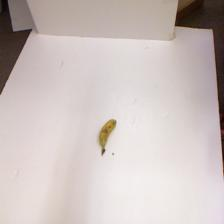
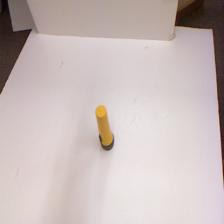
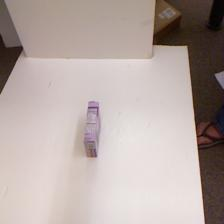
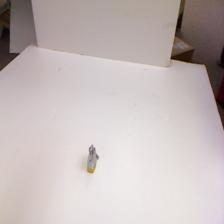

--- Evaluation complete ---

Starting training for 574 steps...
step:   1/574 | lr: 0.00052 | loss: 3.9431

--- Running evaluation at step 1 ---



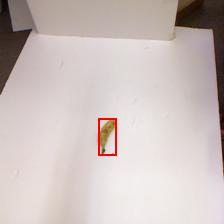
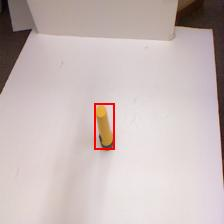
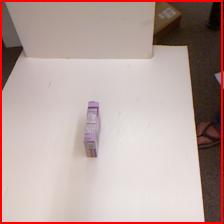
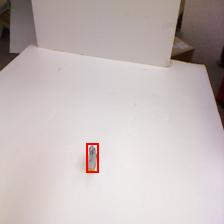

--- Evaluation complete ---

step:   2/574 | lr: 0.00103 | loss: 2.7397
step:   3/574 | lr: 0.00155 | loss: 2.0664
step:   4/574 | lr: 0.00207 | loss: 1.9382
step:   5/574 | lr: 0.00259 | loss: 2.6926
step:   6/574 | lr: 0.00310 | loss: 3.0544
step:   7/574 | lr: 0.00362 | loss: 4.0550
step:   8/574 | lr: 0.00414 | loss: 2.4084
step:   9/574 | lr: 0.00466 | loss: 2.3437
step:  10/574 | lr: 0.00517 | loss: 1.7925
step:  11/574 | lr: 0.00569 | loss: 2.7836
step:  12/574 | lr: 0.00621 | loss: 1.8920
step:  13/574 | lr: 0.00672 | loss: 1.5015
step:  14/574 | lr: 0.00724 | loss: 1.2596
step:  15/574 | lr: 0.00776 | loss: 1.1923
step:  16/574 | lr: 0.00828 | loss: 1.2526
step:  17/574 | lr: 0.00879 | loss: 1.3094
step:  18/574 | lr: 0.00931 | loss: 1.1326
step:  19/574 | lr: 0.00983 | loss: 1.0885
step:  20/574 | lr: 0.01034 | loss: 1.1790

--- Running evaluation at step 20 ---


ValueError: y1 must be greater than or equal to y0

In [12]:
import time
# --- 1. Define Training Parameters ---
BATCH_SIZE = 8
TRAIN_EXAMPLES = 4599 # Using the full training set for one epoch
LEARNING_RATE = 0.03
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 5

# --- 2. Create Learning Rate Schedule and Training Iterator ---
train_data_it = train_data_iterator()
sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

# --- Evaluation at Step 0 (Before Training) ---
print("\n--- Running evaluation at step 0 ---")
html_output = ""
validation_it = validation_data_iterator()

predictions = make_predictions(validation_it, num_examples=4, batch_size=4)

for image_array, model_response in predictions:
    html_output += render_detection_example(image_array, model_response)

display(HTML(html_output))
print("--- Evaluation complete ---\n")

# --- 3. Run the Training Loop with Evals at Specific Points ---
print(f"Starting training for {TRAIN_STEPS} steps...")
start_time = time.time()
for step in range(1, TRAIN_STEPS + 1):
    # --- Training Step ---
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

    keys = examples[0].keys()
    batch = {k: np.stack([ex[k] for ex in examples]) for k in keys}

    batch = big_vision.utils.reshard(batch, data_sharding)

    learning_rate = sched_fn(step)
    params, loss = update_fn(params, batch, learning_rate)
    loss = jax.device_get(loss)
    print(f"step: {step:3d}/{TRAIN_STEPS:3d} | lr: {learning_rate:.5f} | loss: {loss:.4f}")

    # --- Specific Evaluations: After Step 1 and Step 20 ---
    if step == 1 or step == 20:
        print(f"\n--- Running evaluation at step {step} ---")
        html_output = ""
        validation_it = validation_data_iterator()

        predictions = make_predictions(validation_it, num_examples=4, batch_size=4)

        for image_array, model_response in predictions:
            html_output += render_detection_example(image_array, model_response)

        display(HTML(html_output))
        print("--- Evaluation complete ---\n")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

# Save the final checkpoint

In [46]:
def npsave(pytree, path):
  names_and_vals, _ = big_vision.utils.tree_flatten_with_names(pytree)
  with open(path, "wb") as f:
    np.savez(f, **{k:v for k, v in names_and_vals})

# Takes around 4 minutes
npsave(params, 'my-custom-paligemma-ckpt.npz')

In [14]:
# Run this cell once to define all necessary helper functions

import time
import re
import base64
import io
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, HTML
import jax

# --- Data and Metric Helpers ---

def calculate_iou(boxA, boxB):
    """Calculates the IoU of two bounding boxes [xmin, ymin, xmax, ymax]."""
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = float(boxAArea + boxBArea - interArea)
    return interArea / unionArea if unionArea > 0 else 0

def parse_ground_truth(suffix_string):
    """Parses a suffix like '<loc...><loc...> grasp' into a bounding box."""
    loc_values = re.findall(r'<loc(\d+)>', suffix_string)
    if len(loc_values) < 4: return None
    vals = [int(v) for v in loc_values]
    ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
    xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
    ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
    xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

def calculate_metrics(tp, fp, fn):
    """Calculates precision, recall, and F1-score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {"precision": precision, "recall": recall, "f1_score": f1}

# --- Visualization Helper ---

def render_comparison_image_updated(image_path, all_gt_boxes, pred_box_def, pred_box_ft):
    """Renders an image with all ground truth boxes and predictions."""
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    # Draw Ground Truths (Green)
    for i, gt_box in enumerate(all_gt_boxes):
        draw.rectangle(gt_box, outline='lime', width=3)
        if i == 0: draw.text((gt_box[0] + 5, gt_box[1] - 15), "Ground Truth(s)", fill='lime')
    # Draw Default Model Prediction (Blue)
    if pred_box_def:
        draw.rectangle(pred_box_def, outline='dodgerblue', width=3, dash=[10, 5])
        draw.text((pred_box_def[0] + 5, pred_box_def[3] - 15), "Default", fill='dodgerblue')
    # Draw Fine-Tuned Model Prediction (Red)
    if pred_box_ft:
        draw.rectangle(pred_box_ft, outline='red', width=3)
        draw.text((pred_box_ft[0] + 5, pred_box_ft[1] + 5), "Fine-Tuned", fill='red')
    with io.BytesIO() as buffer:
        image.resize((320, 240)).save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return (f'<div style="display: inline-flex; flex-direction: column; margin: 10px;">'
            f'<img style="width:320px; height: 240px;" src="data:image/jpeg;base64,{image_b64}" />'
            f'</div>')


--- Evaluating Fine-Tuned Model (on GPU) ---
✅ Fine-tuned model loaded into RAM.


Moving Fine-Tuned Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Fine-tuned model is on the GPU.


Fine-Tuned Model GPU Eval (Iterator):   0%|          | 0/100 [00:00<?, ?it/s]


--- DEBUG: Fine-Tuned Model Eval, Image 0 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/08/pcd0858r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predicted Tokens (first 10): [235322   2685 235308 235308 235284   2577   2685 235310 235310 235321]
  Post-processed Text: '<loc552><loc448><loc657><loc521> grasp'
  Extracted BBox: [280, 258, 325, 307]
----------------------------------------

--- DEBUG: Fine-Tuned Model Eval, Image 1 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/05/pcd0509r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0),


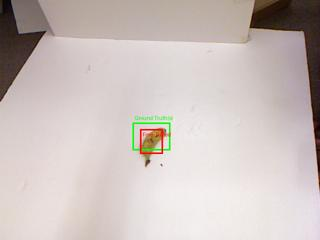
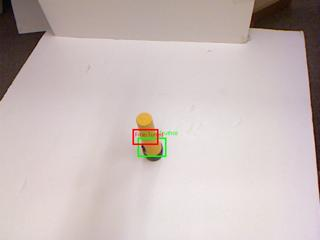
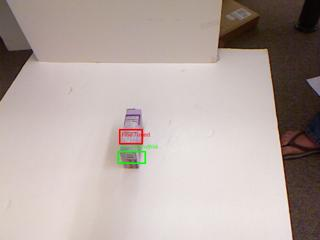
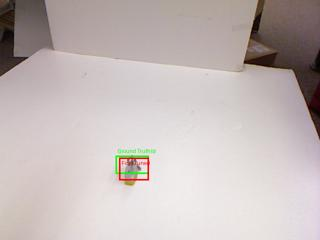

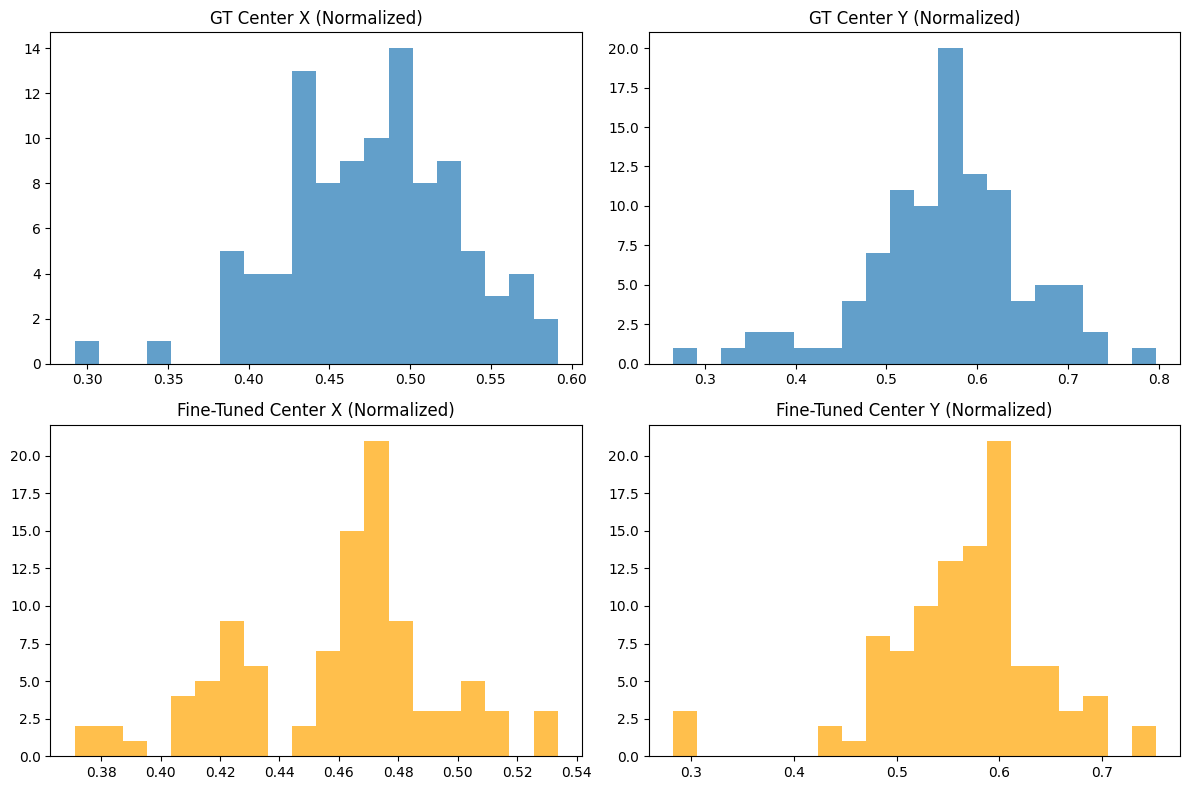

In [16]:
import time
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import re
import tensorflow as tf # Needed for tf.TensorSpec in iterator
from PIL import Image
import functools
import random
import matplotlib.pyplot as plt
# --- Assume these are imported or defined elsewhere in your notebook env ---
# import big_vision.utils
# import big_vision.sharding
# from big_vision.models.proj.paligemma import paligemma
# from big_vision.trainers.proj.paligemma import predict_fns
# import ml_collections
# import sentencepiece
# from IPython.display import display, HTML

# --- Assume constants like PROMPT_PREFIX, SEQLEN, ORIGINAL_IMG_WIDTH, ORIGINAL_IMG_HEIGHT,
# MODEL_PATH, LLM_VARIANT, TOKENIZER_PATH, model_config, tokenizer, preprocess_image,
# preprocess_tokens, postprocess_tokens, decode_bbox_from_output, calculate_iou,
# calculate_metrics, render_comparison_image_updated, data_sharding, params_sharding,
# val_examples are defined or imported from your training setup. ---

# Ensure the decode function is correctly defined (matching training notebook)
# decode_fn = predict_fns.get_all(model)['decode']
# decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

# --- 1. Define the memory-efficient loading logic (from training script) ---
def is_trainable_param(name, param):
  # Match the training script's logic exactly
  if name.startswith("llm/layers/attn/"): return True
  if name.startswith("llm/"): return False
  if name.startswith("img/"): return False
  # Training script raises ValueError, but for loading, False is safer for unmatched.
  return False

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p.astype(jnp.float16),
                      params, trainable)

# --- 2. Group the validation data ---
# Assuming val_examples is available from your training setup
# parse_ground_truth should be defined or imported
# def parse_ground_truth(suffix_str): ...
validation_data_grouped = defaultdict(list)
for example in val_examples:
    gt_box = parse_ground_truth(example["suffix"]) # Implement or import this
    if gt_box:
        validation_data_grouped[example["image_path"]].append(gt_box)

# --- Function to decode bbox (Copied from your notebook for completeness) ---
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values[:4]]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError) as e:
        return None

# --- Function to calculate metrics (Implement or import) ---
def calculate_metrics(tp, fp, fn):
    """Calculates precision, recall, and F1-score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {"precision": precision, "recall": recall, "f1_score": f1_score}


# --- 4. Evaluate the FINE-TUNED Model on the GPU ---
print("\n--- Evaluating Fine-Tuned Model (on GPU) ---")
# Load params from disk into RAM
finetuned_model_path = '/content/Cornell_Grasp_Kaggle/my-custom-paligemma-ckpt.npz' # Path to your checkpoint
params_finetuned = paligemma.load(None, finetuned_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_finetuned)
print("✅ Fine-tuned model loaded into RAM.")

# Move params to GPU memory efficiently
params_finetuned, treedef = jax.tree.flatten(params_finetuned)
# >>>> CRITICAL FIX: Generate NEW sharding_leaves for the fine-tuned model <<<<
sharding_leaves_ft = jax.tree.leaves(params_sharding) # <-- NEW variable for FINE-TUNED model
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves_ft, trainable_leaves), total=len(sharding_leaves_ft), desc="Moving Fine-Tuned Model to GPU")):
  params_finetuned[idx] = big_vision.utils.reshard(params_finetuned[idx], sharding)
  params_finetuned[idx] = maybe_cast_to_f32(params_finetuned[idx], trainable)
  params_finetuned[idx].block_until_ready()
params_finetuned = jax.tree.unflatten(treedef, params_finetuned)
print("✅ Fine-tuned model is on the GPU.")

# Run evaluation loop (on the SAME subset of images for fair comparison)
tp_ft, fp_ft, fn_ft = 0, 0, 0

# Get the list of unique image paths for a controlled evaluation
unique_image_paths_list = list(validation_data_grouped.keys())

# --- CHANGE THIS NUMBER TO REDUCE EVALUATION SIZE ---
NUM_EVAL_EXAMPLES = 100 # e.g., change to 20
unique_image_paths_list = unique_image_paths_list[:NUM_EVAL_EXAMPLES]
# Create a temporary dict for quick lookup of gt_boxes by path
gt_lookup = {path: boxes for path, boxes in validation_data_grouped.items() if path in unique_image_paths_list}
# Create a set for quick lookup of paths we want to evaluate
image_paths_set = set(unique_image_paths_list)
# --- END CHANGE ---

# --- Create a temporary validation iterator that yields only the images we want ---
# Define IMAGE_SIZE constant needed for tf.data
IMAGE_SIZE = 224 # This is the size images are resized to by preprocess_image

def temp_validation_iterator_for_eval(image_paths_subset):
    """A temporary iterator that yields validation examples for a specific subset of image paths."""
    for original_example in val_examples:
        if original_example["image_path"] in image_paths_subset:
            image = Image.open(original_example["image_path"])
            image_processed = preprocess_image(image)
            tokens, mask_ar, _, mask_input = preprocess_tokens(
                prefix=PROMPT_PREFIX, seqlen=SEQLEN
            )
            yield {
                "image": image_processed,
                "text": tokens,
                "mask_ar": mask_ar,
                "mask_input": mask_input,
                "_mask": np.array(True),
                "image_path": original_example["image_path"] # Include for easy lookup
            }

eval_iterator_ft = temp_validation_iterator_for_eval(image_paths_set) # Use the set defined earlier

examples_buffer_ft = []
example_count_ft = 0
debug_print_count_ft = 0
DEBUG_PRINT_LIMIT_FT = 3

# Lists for histogram centers
gt_centers_x, gt_centers_y = [], []
pred_centers_x, pred_centers_y = [], []

visualization_preds = {}

batch_size_for_eval = 4 # Use same batch size as training eval for consistency

eval_pbar_ft = tqdm(total=len(unique_image_paths_list), desc="Fine-Tuned Model GPU Eval (Iterator)")

while True:
    try:
        examples_buffer_ft.append(next(eval_iterator_ft))
        eval_pbar_ft.update(1)
    except StopIteration:
        if not examples_buffer_ft:
            break
        while len(examples_buffer_ft) % batch_size_for_eval != 0:
             padded_example = dict(examples_buffer_ft[-1])
             padded_example["_mask"] = np.array(False)
             examples_buffer_ft.append(padded_example)

    if len(examples_buffer_ft) >= batch_size_for_eval and len(examples_buffer_ft) % batch_size_for_eval == 0:
        current_batch_examples = examples_buffer_ft[:batch_size_for_eval]
        examples_buffer_ft = examples_buffer_ft[batch_size_for_eval:]

        if current_batch_examples:
            # Construct batch dict, carefully excluding string/object dtypes
            numeric_keys = ["image", "text", "mask_ar", "mask_input", "_mask"]
            try:
                batch = {k: np.stack([ex[k] for ex in current_batch_examples]) for k in numeric_keys if k in current_batch_examples[0]}
            except ValueError as e:
                 print(f"  [Error] Failed to stack batch for keys {numeric_keys}: {e}")
                 raise

            batch = big_vision.utils.reshard(batch, data_sharding)

            # --- Make predictions ---
            pred_tokens = decode({"params": params_finetuned}, batch=batch, max_decode_len=SEQLEN)

            # --- Process outputs ---
            pred_tokens_cpu, mask_cpu = jax.device_get((pred_tokens, batch["_mask"]))
            valid_pred_tokens = pred_tokens_cpu[mask_cpu]
            valid_batch_examples = [ex for ex, is_valid in zip(current_batch_examples, mask_cpu) if is_valid]

            for i, (example, raw_pred_toks) in enumerate(zip(valid_batch_examples, valid_pred_tokens)):
                image_path = example["image_path"]
                all_gt_boxes = gt_lookup.get(image_path, [])

                post_processed_text = postprocess_tokens(raw_pred_toks)
                pred_box = decode_bbox_from_output(post_processed_text)

                # --- DEBUGGING: Add prints for first few examples ---
                if debug_print_count_ft < DEBUG_PRINT_LIMIT_FT:
                    print(f"\n--- DEBUG: Fine-Tuned Model Eval, Image {debug_print_count_ft} ({image_path}) ---")
                    print(f"  Input Image Shape: {example['image'].shape}")
                    print(f"  Input Tokens (first 10): {example['text'][:10]}")
                    print(f"  Input Mask AR (first 10): {example['mask_ar'][:10]}")
                    print(f"  Raw Predicted Tokens (first 10): {raw_pred_toks[:10]}")
                    print(f"  Post-processed Text: '{post_processed_text}'")
                    print(f"  Extracted BBox: {pred_box}")
                    print("----------------------------------------")
                    debug_print_count_ft += 1

                if pred_box:
                    is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
                    if is_match: tp_ft += 1
                    else: fp_ft += 1
                else:
                    fn_ft += 1

                # Collect for histograms
                if all_gt_boxes:
                    rand_gt = random.choice(all_gt_boxes)
                    gt_center_x = (rand_gt[0] + rand_gt[2]) / 2 / ORIGINAL_IMG_WIDTH
                    gt_center_y = (rand_gt[1] + rand_gt[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    gt_centers_x.append(gt_center_x)
                    gt_centers_y.append(gt_center_y)

                if pred_box:
                    pred_center_x = (pred_box[0] + pred_box[2]) / 2 / ORIGINAL_IMG_WIDTH
                    pred_center_y = (pred_box[1] + pred_box[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    pred_centers_x.append(pred_center_x)
                    pred_centers_y.append(pred_center_y)

                # Update visualization dict
                if example_count_ft < 4:
                     visualization_preds[image_path] = {'gt': all_gt_boxes, 'finetuned_pred': pred_box}

                example_count_ft += 1
                if example_count_ft >= len(unique_image_paths_list):
                    break

        if example_count_ft >= len(unique_image_paths_list):
            break

eval_pbar_ft.close()
# --- End of Batch processing loop for fine-tuned model ---
metrics_ft = calculate_metrics(tp_ft, fp_ft, fn_ft)
print("✅ Evaluation complete for fine-tuned model.")

del params_finetuned, trainable_mask, trainable_leaves, sharding_leaves_ft
jax.clear_caches()
gc.collect()
print("🧹 Fine-tuned model cleared from GPU memory.")


# --- 5. Final Comparison and Visualization ---
print("\n--- Final Evaluation Results ---")
print(f"{'Metric':<12} | {'Fine-Tuned Model':<20}")
print("-" * 55)
print(f"{'Precision':<12} | {metrics_ft['precision']:.4f}")
print(f"{'Recall':<12} | {metrics_ft['recall']:.4f}")
print(f"{'F1-Score':<12} | {metrics_ft['f1_score']:.4f}")
print("-" * 55)

# Render the visualizations using the saved predictions (if function exists)
print("\n--- Visual Comparison ---")
print("🟩 Ground Truth(s) | 🟥 Fine-Tuned")
html_output = ""
for image_path, preds in visualization_preds.items():
    # Check if we have predictions for both models for this image
    if 'finetuned_pred' in preds:
        html_output += render_comparison_image_updated(
            image_path,
            preds['gt'],
            None,  # No default
            preds.get('finetuned_pred')
        )
display(HTML(html_output))

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
bins = 20

axs[0, 0].hist(gt_centers_x, bins=bins, alpha=0.7, label='GT')
axs[0, 0].set_title('GT Center X (Normalized)')
axs[0, 1].hist(gt_centers_y, bins=bins, alpha=0.7, label='GT')
axs[0, 1].set_title('GT Center Y (Normalized)')

axs[1, 0].hist(pred_centers_x, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 0].set_title('Fine-Tuned Center X (Normalized)')
axs[1, 1].hist(pred_centers_y, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 1].set_title('Fine-Tuned Center Y (Normalized)')

plt.tight_layout()
plt.show()

In [25]:
import time
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import re
import tensorflow as tf # Needed for tf.TensorSpec in iterator
from PIL import Image
import functools
import random
import matplotlib.pyplot as plt
# --- Assume these are imported or defined elsewhere in your notebook env ---
# import big_vision.utils
# import big_vision.sharding
# from big_vision.models.proj.paligemma import paligemma
# from big_vision.trainers.proj.paligemma import predict_fns
# import ml_collections
# import sentencepiece
# from IPython.display import display, HTML

# --- Assume constants like PROMPT_PREFIX, SEQLEN, ORIGINAL_IMG_WIDTH, ORIGINAL_IMG_HEIGHT,
# MODEL_PATH, LLM_VARIANT, TOKENIZER_PATH, model_config, tokenizer, preprocess_image,
# preprocess_tokens, postprocess_tokens, decode_bbox_from_output, calculate_iou,
# calculate_metrics, render_comparison_image_updated, data_sharding, params_sharding,
# val_examples are defined or imported from your training setup. ---

# Ensure the decode function is correctly defined (matching training notebook)
# decode_fn = predict_fns.get_all(model)['decode']
# decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

# --- 1. Define the memory-efficient loading logic (from training script) ---
def is_trainable_param(name, param):
  # Match the training script's logic exactly
  if name.startswith("llm/layers/attn/"): return True
  if name.startswith("llm/"): return False
  if name.startswith("img/"): return False
  # Training script raises ValueError, but for loading, False is safer for unmatched.
  return False

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p.astype(jnp.float16),
                      params, trainable)

# --- 2. Group the validation data ---
# Assuming val_examples is available from your training setup
# parse_ground_truth should be defined or imported
# def parse_ground_truth(suffix_str): ...
validation_data_grouped = defaultdict(list)
for example in val_examples:
    gt_box = parse_ground_truth(example["suffix"]) # Implement or import this
    if gt_box:
        validation_data_grouped[example["image_path"]].append(gt_box)

# --- Function to decode bbox (Copied from your notebook for completeness) ---
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values[:4]]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError) as e:
        return None

# --- Function to calculate metrics (Implement or import) ---
def calculate_metrics(tp, fp, fn):
    """Calculates precision, recall, and F1-score."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {"precision": precision, "recall": recall, "f1_score": f1_score}


# --- 4. Evaluate the FINE-TUNED Model on the GPU ---
print("\n--- Evaluating Fine-Tuned Model (on GPU) ---")
# Load params from disk into RAM
finetuned_model_path = '/content/Cornell_Grasp_Kaggle/my-custom-paligemma-ckpt.npz' # Path to your checkpoint
params_finetuned = paligemma.load(None, finetuned_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_finetuned)
print("✅ Fine-tuned model loaded into RAM.")

# Move params to GPU memory efficiently
params_finetuned, treedef = jax.tree.flatten(params_finetuned)
# >>>> CRITICAL FIX: Generate NEW sharding_leaves for the fine-tuned model <<<<
sharding_leaves_ft = jax.tree.leaves(params_sharding) # <-- NEW variable for FINE-TUNED model
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves_ft, trainable_leaves), total=len(sharding_leaves_ft), desc="Moving Fine-Tuned Model to GPU")):
  params_finetuned[idx] = big_vision.utils.reshard(params_finetuned[idx], sharding)
  params_finetuned[idx] = maybe_cast_to_f32(params_finetuned[idx], trainable)
  params_finetuned[idx].block_until_ready()
params_finetuned = jax.tree.unflatten(treedef, params_finetuned)
print("✅ Fine-tuned model is on the GPU.")

# Run evaluation loop (on the SAME subset of images for fair comparison)
tp_ft, fp_ft, fn_ft = 0, 0, 0

# Get the list of unique image paths for a controlled evaluation
unique_image_paths_list = list(validation_data_grouped.keys())

# --- CHANGE THIS NUMBER TO REDUCE EVALUATION SIZE ---
NUM_EVAL_EXAMPLES = 20 # e.g., change to 20
unique_image_paths_list = unique_image_paths_list[:NUM_EVAL_EXAMPLES]
# Create a temporary dict for quick lookup of gt_boxes by path
gt_lookup = {path: boxes for path, boxes in validation_data_grouped.items() if path in unique_image_paths_list}
# Create a set for quick lookup of paths we want to evaluate
image_paths_set = set(unique_image_paths_list)
# --- END CHANGE ---

# --- Create a temporary validation iterator that yields only the images we want ---
# Define IMAGE_SIZE constant needed for tf.data
IMAGE_SIZE = 224 # This is the size images are resized to by preprocess_image

def temp_validation_iterator_for_eval(image_paths_subset):
    """A temporary iterator that yields validation examples for a specific subset of image paths."""
    for original_example in val_examples:
        if original_example["image_path"] in image_paths_subset:
            image = Image.open(original_example["image_path"])
            image_processed = preprocess_image(image)
            tokens, mask_ar, _, mask_input = preprocess_tokens(
                prefix=PROMPT_PREFIX, seqlen=SEQLEN
            )
            yield {
                "image": image_processed,
                "text": tokens,
                "mask_ar": mask_ar,
                "mask_input": mask_input,
                "_mask": np.array(True),
                "image_path": original_example["image_path"] # Include for easy lookup
            }

eval_iterator_ft = temp_validation_iterator_for_eval(image_paths_set) # Use the set defined earlier

examples_buffer_ft = []
example_count_ft = 0
debug_print_count_ft = 0
DEBUG_PRINT_LIMIT_FT = 3

# Lists for histogram centers
gt_centers_x, gt_centers_y = [], []
pred_centers_x, pred_centers_y = [], []

visualization_preds = {}

batch_size_for_eval = 4 # Use same batch size as training eval for consistency

eval_pbar_ft = tqdm(total=len(unique_image_paths_list), desc="Fine-Tuned Model GPU Eval (Iterator)")

while True:
    try:
        examples_buffer_ft.append(next(eval_iterator_ft))
        eval_pbar_ft.update(1)
    except StopIteration:
        if not examples_buffer_ft:
            break
        while len(examples_buffer_ft) % batch_size_for_eval != 0:
             padded_example = dict(examples_buffer_ft[-1])
             padded_example["_mask"] = np.array(False)
             examples_buffer_ft.append(padded_example)

    if len(examples_buffer_ft) >= batch_size_for_eval and len(examples_buffer_ft) % batch_size_for_eval == 0:
        current_batch_examples = examples_buffer_ft[:batch_size_for_eval]
        examples_buffer_ft = examples_buffer_ft[batch_size_for_eval:]

        if current_batch_examples:
            # Construct batch dict, carefully excluding string/object dtypes
            numeric_keys = ["image", "text", "mask_ar", "mask_input", "_mask"]
            try:
                batch = {k: np.stack([ex[k] for ex in current_batch_examples]) for k in numeric_keys if k in current_batch_examples[0]}
            except ValueError as e:
                 print(f"  [Error] Failed to stack batch for keys {numeric_keys}: {e}")
                 raise

            batch = big_vision.utils.reshard(batch, data_sharding)

            # --- Make predictions ---
            pred_tokens = decode({"params": params_finetuned}, batch=batch, max_decode_len=SEQLEN)

            # --- Process outputs ---
            pred_tokens_cpu, mask_cpu = jax.device_get((pred_tokens, batch["_mask"]))
            valid_pred_tokens = pred_tokens_cpu[mask_cpu]
            valid_batch_examples = [ex for ex, is_valid in zip(current_batch_examples, mask_cpu) if is_valid]

            for i, (example, raw_pred_toks) in enumerate(zip(valid_batch_examples, valid_pred_tokens)):
                image_path = example["image_path"]
                all_gt_boxes = gt_lookup.get(image_path, [])

                post_processed_text = postprocess_tokens(raw_pred_toks)
                pred_box = decode_bbox_from_output(post_processed_text)

                # --- DEBUGGING: Add prints for first few examples ---
                if debug_print_count_ft < DEBUG_PRINT_LIMIT_FT:
                    print(f"\n--- DEBUG: Fine-Tuned Model Eval, Image {debug_print_count_ft} ({image_path}) ---")
                    print(f"  Input Image Shape: {example['image'].shape}")
                    print(f"  Input Tokens (first 10): {example['text'][:10]}")
                    print(f"  Input Mask AR (first 10): {example['mask_ar'][:10]}")
                    print(f"  Raw Predicted Tokens (first 10): {raw_pred_toks[:10]}")
                    print(f"  Post-processed Text: '{post_processed_text}'")
                    print(f"  Extracted BBox: {pred_box}")
                    print("----------------------------------------")
                    debug_print_count_ft += 1

                if pred_box:
                    is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
                    if is_match: tp_ft += 1
                    else: fp_ft += 1
                else:
                    fn_ft += 1

                # Collect for histograms
                if all_gt_boxes:
                    rand_gt = random.choice(all_gt_boxes)
                    gt_center_x = (rand_gt[0] + rand_gt[2]) / 2 / ORIGINAL_IMG_WIDTH
                    gt_center_y = (rand_gt[1] + rand_gt[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    gt_centers_x.append(gt_center_x)
                    gt_centers_y.append(gt_center_y)

                if pred_box:
                    pred_center_x = (pred_box[0] + pred_box[2]) / 2 / ORIGINAL_IMG_WIDTH
                    pred_center_y = (pred_box[1] + pred_box[3]) / 2 / ORIGINAL_IMG_HEIGHT
                    pred_centers_x.append(pred_center_x)
                    pred_centers_y.append(pred_center_y)

                # Update visualization dict
                if example_count_ft < 4:
                     visualization_preds[image_path] = {'gt': all_gt_boxes, 'finetuned_pred': pred_box}

                example_count_ft += 1
                if example_count_ft >= len(unique_image_paths_list):
                    break

        if example_count_ft >= len(unique_image_paths_list):
            break

eval_pbar_ft.close()
# --- End of Batch processing loop for fine-tuned model ---
metrics_ft = calculate_metrics(tp_ft, fp_ft, fn_ft)
print("✅ Evaluation complete for fine-tuned model.")

del params_finetuned, trainable_mask, trainable_leaves, sharding_leaves_ft
jax.clear_caches()
gc.collect()
print("🧹 Fine-tuned model cleared from GPU memory.")


# --- 5. Final Comparison and Visualization ---
print("\n--- Final Evaluation Results ---")
print(f"{'Metric':<12} | {'Fine-Tuned Model':<20}")
print("-" * 55)
print(f"{'Precision':<12} | {metrics_ft['precision']:.4f}")
print(f"{'Recall':<12} | {metrics_ft['recall']:.4f}")
print(f"{'F1-Score':<12} | {metrics_ft['f1_score']:.4f}")
print("-" * 55)

# Render the visualizations using the saved predictions (if function exists)
print("\n--- Visual Comparison ---")
print("🟩 Ground Truth(s) | 🟥 Fine-Tuned")
html_output = ""
for image_path, preds in visualization_preds.items():
    # Check if we have predictions for both models for this image
    if 'finetuned_pred' in preds:
        html_output += render_comparison_image_updated(
            image_path,
            preds['gt'],
            None,  # No default
            preds.get('finetuned_pred')
        )
display(HTML(html_output))

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
bins = 20

axs[0, 0].hist(gt_centers_x, bins=bins, alpha=0.7, label='GT')
axs[0, 0].set_title('GT Center X (Normalized)')
axs[0, 1].hist(gt_centers_y, bins=bins, alpha=0.7, label='GT')
axs[0, 1].set_title('GT Center Y (Normalized)')

axs[1, 0].hist(pred_centers_x, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 0].set_title('Fine-Tuned Center X (Normalized)')
axs[1, 1].hist(pred_centers_y, bins=bins, alpha=0.7, label='Fine-Tuned', color='orange')
axs[1, 1].set_title('Fine-Tuned Center Y (Normalized)')

plt.tight_layout()
plt.show()

--- Evaluating Default Model (on GPU) ---
✅ Default model loaded into RAM.


Moving Default Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Default model is on the GPU.


Default Model GPU Eval (Iterator):   0%|          | 0/20 [00:00<?, ?it/s]


--- DEBUG: Default Model Eval, Image 0 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/03/pcd0388r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predicted Tokens (first 10): [235322   2685 235308 235274 235284   2577   2685 235310 235310 235321]
  Post-processed Text: '<loc512><loc448><loc618><loc507> grasp'
  Extracted BBox: [280, 240, 316, 289]
----------------------------------------

--- DEBUG: Default Model Eval, Image 1 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/06/pcd0659r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array

Moving Fine-Tuned Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Fine-tuned model is on the GPU.


Fine-Tuned Model GPU Eval (Iterator):   0%|          | 0/20 [00:00<?, ?it/s]


--- DEBUG: Fine-Tuned Model Eval, Image 0 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/03/pcd0388r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predicted Tokens (first 10): [1 0 0 0 0 0 0 0 0 0]
  Post-processed Text: ''
  Extracted BBox: None
----------------------------------------

--- DEBUG: Fine-Tuned Model Eval, Image 1 (/content/drive/MyDrive/datasets/Cornell_Grasp_Kaggle/06/pcd0659r.png) ---
  Input Image Shape: (224, 224, 3)
  Input Tokens (first 10): [array(2), array(39208), array(30506), array(108), array(0), array(0), array(0), array(0), array(0), array(0)]
  Input Mask AR (first 10): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0)]
  Raw Predict

--- Evaluating Default Model (on GPU) ---
✅ Default model loaded into RAM.


Moving Default Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Default model is on the GPU.


Default Model GPU Eval:   0%|          | 0/375 [00:00<?, ?it/s]

✅ Evaluation complete for default model.
🧹 Default model cleared from GPU memory.

--- Evaluating Fine-Tuned Model (on GPU) ---
✅ Fine-tuned model loaded into RAM.


Moving Fine-Tuned Model to GPU:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Fine-tuned model is on the GPU.


Fine-Tuned Model GPU Eval:   0%|          | 0/375 [00:00<?, ?it/s]

✅ Evaluation complete for fine-tuned model.
🧹 Fine-tuned model cleared from GPU memory.

--- Final Evaluation Results ---
Metric       | Fine-Tuned Model     | Default Model
-------------------------------------------------------
Precision    | 0.1360                | 0.0000
Recall       | 1.0000                | 0.0000
F1-Score     | 0.2394                | 0.0000
-------------------------------------------------------

--- Visual Comparison ---
🟩 Ground Truth(s) | 🟥 Fine-Tuned | 🟦 Default (dashed)



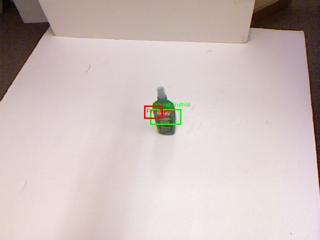
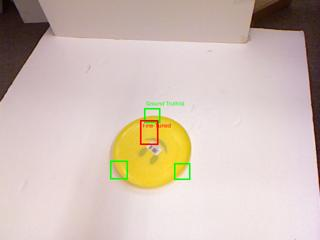
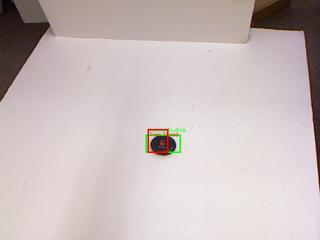
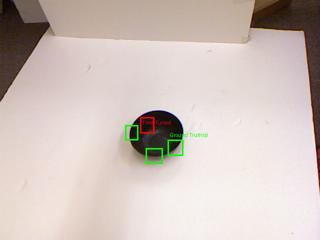

In [17]:
# ==============================================================================
#
#               FINAL GPU EVALUATION SCRIPT
#
# ==============================================================================
import time
import gc
from collections import defaultdict
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import numpy as np

# --- 1. Define the memory-efficient loading logic from your training script ---

# This mask determines which params are cast to float32 (trainable) vs float16 (frozen)
def is_trainable_param(name, param):
  if name.startswith("llm/layers/attn/"): return True
  return False

# This JIT'd function efficiently casts the parameters on the device
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p.astype(jnp.float16),
                      params, trainable)

# --- 2. Group the validation data ---
validation_data_grouped = defaultdict(list)
for example in val_examples:
    gt_box = parse_ground_truth(example["suffix"])
    if gt_box:
        validation_data_grouped[example["image_path"]].append(gt_box)

# --- 3. Evaluate the DEFAULT Model on the GPU ---

print("--- Evaluating Default Model (on GPU) ---")
# Load params from disk into RAM
default_model_path = MODEL_PATH
params_default = paligemma.load(None, default_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_default)
print("✅ Default model loaded into RAM.")

# Move params to GPU memory efficiently, param by param
params_default, treedef = jax.tree.flatten(params_default)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves, trainable_leaves), total=len(sharding_leaves), desc="Moving Default Model to GPU")):
  params_default[idx] = big_vision.utils.reshard(params_default[idx], sharding)
  params_default[idx] = maybe_cast_to_f32(params_default[idx], trainable)
params_default = jax.tree.unflatten(treedef, params_default)
print("✅ Default model is on the GPU.")

# Run evaluation loop
tp_def, fp_def, fn_def = 0, 0, 0
unique_image_paths = list(validation_data_grouped.keys())
visualization_preds = {}

for i, image_path in enumerate(tqdm(unique_image_paths, desc="Default Model GPU Eval")):
    all_gt_boxes = validation_data_grouped[image_path]
    image = preprocess_image(Image.open(image_path))
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix=PROMPT_PREFIX, seqlen=SEQLEN)
    batch = {
        "image": np.array([image]), "text": np.array([tokens]),
        "mask_input": np.array([mask_input]), "mask_ar": np.array([mask_ar]),
        "_mask": np.array([True])
    }
    batch = big_vision.utils.reshard(batch, data_sharding)

    pred_tok = decode({"params": params_default}, batch=batch, max_decode_len=SEQLEN)
    pred_box = decode_bbox_from_output(postprocess_tokens(jax.device_get(pred_tok)[0]))

    if pred_box:
        is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
        if is_match: tp_def += 1
        else: fp_def += 1
    else:
        fn_def += 1
    if i < 4:
        visualization_preds[image_path] = {'gt': all_gt_boxes, 'default_pred': pred_box}

metrics_def = calculate_metrics(tp_def, fp_def, fn_def)
print("✅ Evaluation complete for default model.")

# CRITICAL STEP: Clear model from GPU memory
del params_default, trainable_mask, trainable_leaves
jax.clear_caches()
gc.collect()
print("🧹 Default model cleared from GPU memory.")


# --- 4. Evaluate the FINE-TUNED Model on the GPU ---

print("\n--- Evaluating Fine-Tuned Model (on GPU) ---")
# Load params from disk into RAM
finetuned_model_path = '/content/Cornell_Grasp_Kaggle/my-custom-paligemma-ckpt.npz'
params_finetuned = paligemma.load(None, finetuned_model_path, model_config)
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params_finetuned)
print("✅ Fine-tuned model loaded into RAM.")

# Move params to GPU memory efficiently
params_finetuned, treedef = jax.tree.flatten(params_finetuned)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(tqdm(zip(sharding_leaves, trainable_leaves), total=len(sharding_leaves), desc="Moving Fine-Tuned Model to GPU")):
  params_finetuned[idx] = big_vision.utils.reshard(params_finetuned[idx], sharding)
  params_finetuned[idx] = maybe_cast_to_f32(params_finetuned[idx], trainable)
params_finetuned = jax.tree.unflatten(treedef, params_finetuned)
print("✅ Fine-tuned model is on the GPU.")

# Run evaluation loop
tp_ft, fp_ft, fn_ft = 0, 0, 0
for i, image_path in enumerate(tqdm(unique_image_paths, desc="Fine-Tuned Model GPU Eval")):
    all_gt_boxes = validation_data_grouped[image_path]
    image = preprocess_image(Image.open(image_path))
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix=PROMPT_PREFIX, seqlen=SEQLEN)
    batch = {
        "image": np.array([image]), "text": np.array([tokens]),
        "mask_input": np.array([mask_input]), "mask_ar": np.array([mask_ar]),
        "_mask": np.array([True])
    }
    batch = big_vision.utils.reshard(batch, data_sharding)
    pred_tok = decode({"params": params_finetuned}, batch=batch, max_decode_len=SEQLEN)
    pred_box = decode_bbox_from_output(postprocess_tokens(jax.device_get(pred_tok)[0]))

    if pred_box:
        is_match = any(calculate_iou(gt, pred_box) >= 0.5 for gt in all_gt_boxes)
        if is_match: tp_ft += 1
        else: fp_ft += 1
    else:
        fn_ft += 1
    if i < 4:
        visualization_preds[image_path]['finetuned_pred'] = pred_box

metrics_ft = calculate_metrics(tp_ft, fp_ft, fn_ft)
print("✅ Evaluation complete for fine-tuned model.")

del params_finetuned, trainable_mask, trainable_leaves
jax.clear_caches()
gc.collect()
print("🧹 Fine-tuned model cleared from GPU memory.")


# --- 5. Final Comparison and Visualization ---
print("\n--- Final Evaluation Results ---")
print(f"{'Metric':<12} | {'Fine-Tuned Model':<20} | {'Default Model'}")
print("-" * 55)
print(f"{'Precision':<12} | {metrics_ft['precision']:.4f}{'':<15} | {metrics_def['precision']:.4f}")
print(f"{'Recall':<12} | {metrics_ft['recall']:.4f}{'':<15} | {metrics_def['recall']:.4f}")
print(f"{'F1-Score':<12} | {metrics_ft['f1_score']:.4f}{'':<15} | {metrics_def['f1_score']:.4f}")
print("-" * 55)

# Render the visualizations using the saved predictions
print("\n--- Visual Comparison ---")
print("🟩 Ground Truth(s) | 🟥 Fine-Tuned | 🟦 Default (dashed)")
html_output = ""
for image_path, preds in visualization_preds.items():
    html_output += render_comparison_image_updated(
        image_path,
        preds['gt'],
        preds.get('default_pred'),
        preds.get('finetuned_pred')
    )
display(HTML(html_output))